In [1]:
# Standard libs
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot  as plt

# Data prep
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.impute import SimpleImputer


# Algos
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Model evaluation metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve,recall_score
from sklearn import tree



# Model tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")



# Workflow:
- import the libs
- import the data
- do univariate EDA
- do multivariate EDA
- perform wrangling and cleanup
- attempt t-sne or PCA to see if any patterns are outright visible with the data
- do a naive implementation using logistic regression as a baseline. (assuming we are classifying on 2 classes)
- Try out a few things like (not necessarily in that order);
  - SVM
  - Random Forest,
  - XGBoost,


For all approaches above, get a proxy measure of MSE or equivalent for a number of hyperparams per approach.


## Notes:

- Check which nomalizer is best suited for binary classification (if this is indeed the target)
- See if we can use a keras classifer architecture out of the box instead of winging it.


In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
#dfTravels = pd.read_csv('/content/drive/MyDrive/trains-data/Traveldata_train.csv')
#dfSurveys = pd.read_csv('/content/drive/MyDrive/trains-data/Surveydata_train.csv')

#dfTravels_test = pd.read_csv('/content/drive/MyDrive/trains-data/Traveldata_test.csv')
#dfSurveys_test = pd.read_csv('/content/drive/MyDrive/trains-data/Surveydata_test.csv')

dfTravels = pd.read_csv('trains-data/Traveldata_train.csv')
dfSurveys = pd.read_csv('trains-data/Surveydata_train.csv')

dfTravels_test = pd.read_csv('trains-data/Traveldata_test.csv')
dfSurveys_test = pd.read_csv('trains-data/Surveydata_test.csv')
print("Unique travel train ids:", dfTravels.ID.nunique())
print("Unique survey train ids:", dfSurveys.ID.nunique())
print(48*'*')
print("Unique travel test ids:", dfTravels_test.ID.nunique())
print("Unique survey test ids:", dfSurveys_test.ID.nunique())



Unique travel train ids: 94379
Unique survey train ids: 94379
************************************************
Unique travel test ids: 35602
Unique survey test ids: 35602


In [4]:
# We merge both datasets to get a single view of the data since we have a perfect 1-1 match in IDs.  The inner join will confirm that:

dfMerged_train=pd.merge(dfTravels,dfSurveys, how="inner", on="ID")
dfMerged_train.drop("ID",axis=1,inplace=True)

dfMerged_test=pd.merge(dfTravels_test,dfSurveys_test, how="inner", on="ID")


print('Merged training set: ' ,dfMerged_train.shape,'\n', 'Merged test set: ' ,dfMerged_test.shape,
      )


Merged training set:  (94379, 24) 
 Merged test set:  (35602, 24)


We are getting the same number of  rows out from the inner join meaning we did indeed get a perfect 1 to 1 match on ID.  Now on  to check on data structure and quality

In [5]:
dfMerged_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94379 entries, 0 to 94378
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gender                   94302 non-null  object 
 1   Customer_Type            85428 non-null  object 
 2   Age                      94346 non-null  float64
 3   Type_Travel              85153 non-null  object 
 4   Travel_Class             94379 non-null  object 
 5   Travel_Distance          94379 non-null  int64  
 6   Departure_Delay_in_Mins  94322 non-null  float64
 7   Arrival_Delay_in_Mins    94022 non-null  float64
 8   Overall_Experience       94379 non-null  int64  
 9   Seat_Comfort             94318 non-null  object 
 10  Seat_Class               94379 non-null  object 
 11  Arrival_Time_Convenient  85449 non-null  object 
 12  Catering                 85638 non-null  object 
 13  Platform_Location        94349 non-null  object 
 14  Onboard_Wifi_Service  

The fact that we have floats in otherwise Int fields like DepartureDelay implies null values (pandas defaults to float when we have either NaN or none in a Series of otherwise Int values)

In [6]:
#find null values in dataframe dfMerged
print(dfMerged_train.isnull().sum().sort_values(ascending=False))


Type_Travel                9226
Customer_Type              8951
Arrival_Time_Convenient    8930
Catering                   8741
Onboard_Service            7601
Arrival_Delay_in_Mins       357
Baggage_Handling            142
Online_Support               91
Legroom                      90
CheckIn_Service              77
Gender                       77
Ease_of_Online_Booking       73
Seat_Comfort                 61
Departure_Delay_in_Mins      57
Age                          33
Platform_Location            30
Onboard_Wifi_Service         30
Onboard_Entertainment        18
Cleanliness                   6
Online_Boarding               6
Seat_Class                    0
Overall_Experience            0
Travel_Distance               0
Travel_Class                  0
dtype: int64


Quite a few nulls here and there.  Let's look at the unique values to see if we can work around that.
- Top of the list is type of travel with ~9k missing observations. Customer type, arrival time convenient, catering, and onboard service are in the same order of magnitude. 
- Arrival delay in min, and delayed and bagage handling have a couple of hundred missing observations. 
- The rest of variables with missing values, have less than 100 occurrences. 

In [7]:
dfMerged_train.nunique().sort_values(ascending=False)

Travel_Distance            5210
Departure_Delay_in_Mins     437
Arrival_Delay_in_Mins       434
Age                          75
Catering                      6
Onboard_Wifi_Service          6
Cleanliness                   6
CheckIn_Service               6
Legroom                       6
Onboard_Service               6
Ease_of_Online_Booking        6
Online_Support                6
Onboard_Entertainment         6
Online_Boarding               6
Platform_Location             6
Arrival_Time_Convenient       6
Seat_Comfort                  6
Baggage_Handling              5
Customer_Type                 2
Seat_Class                    2
Overall_Experience            2
Travel_Class                  2
Type_Travel                   2
Gender                        2
dtype: int64

In [8]:
cat_cols = dfMerged_train.select_dtypes(exclude=["number"]).columns
num_cols = dfMerged_train.select_dtypes(include=["number"]).columns
#num cols still holds the target variable at this point (Overall_Experience)

In [9]:
dfMerged_train[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Age,94346.0,39.419647,15.116632,7.0,27.0,40.0,51.0,85.0
Travel_Distance,94379.0,1978.888185,1027.961019,50.0,1359.0,1923.0,2538.0,6951.0
Departure_Delay_in_Mins,94322.0,14.647092,38.138781,0.0,0.0,0.0,12.0,1592.0
Arrival_Delay_in_Mins,94022.0,15.005222,38.439409,0.0,0.0,0.0,13.0,1584.0
Overall_Experience,94379.0,0.546658,0.497821,0.0,0.0,1.0,1.0,1.0


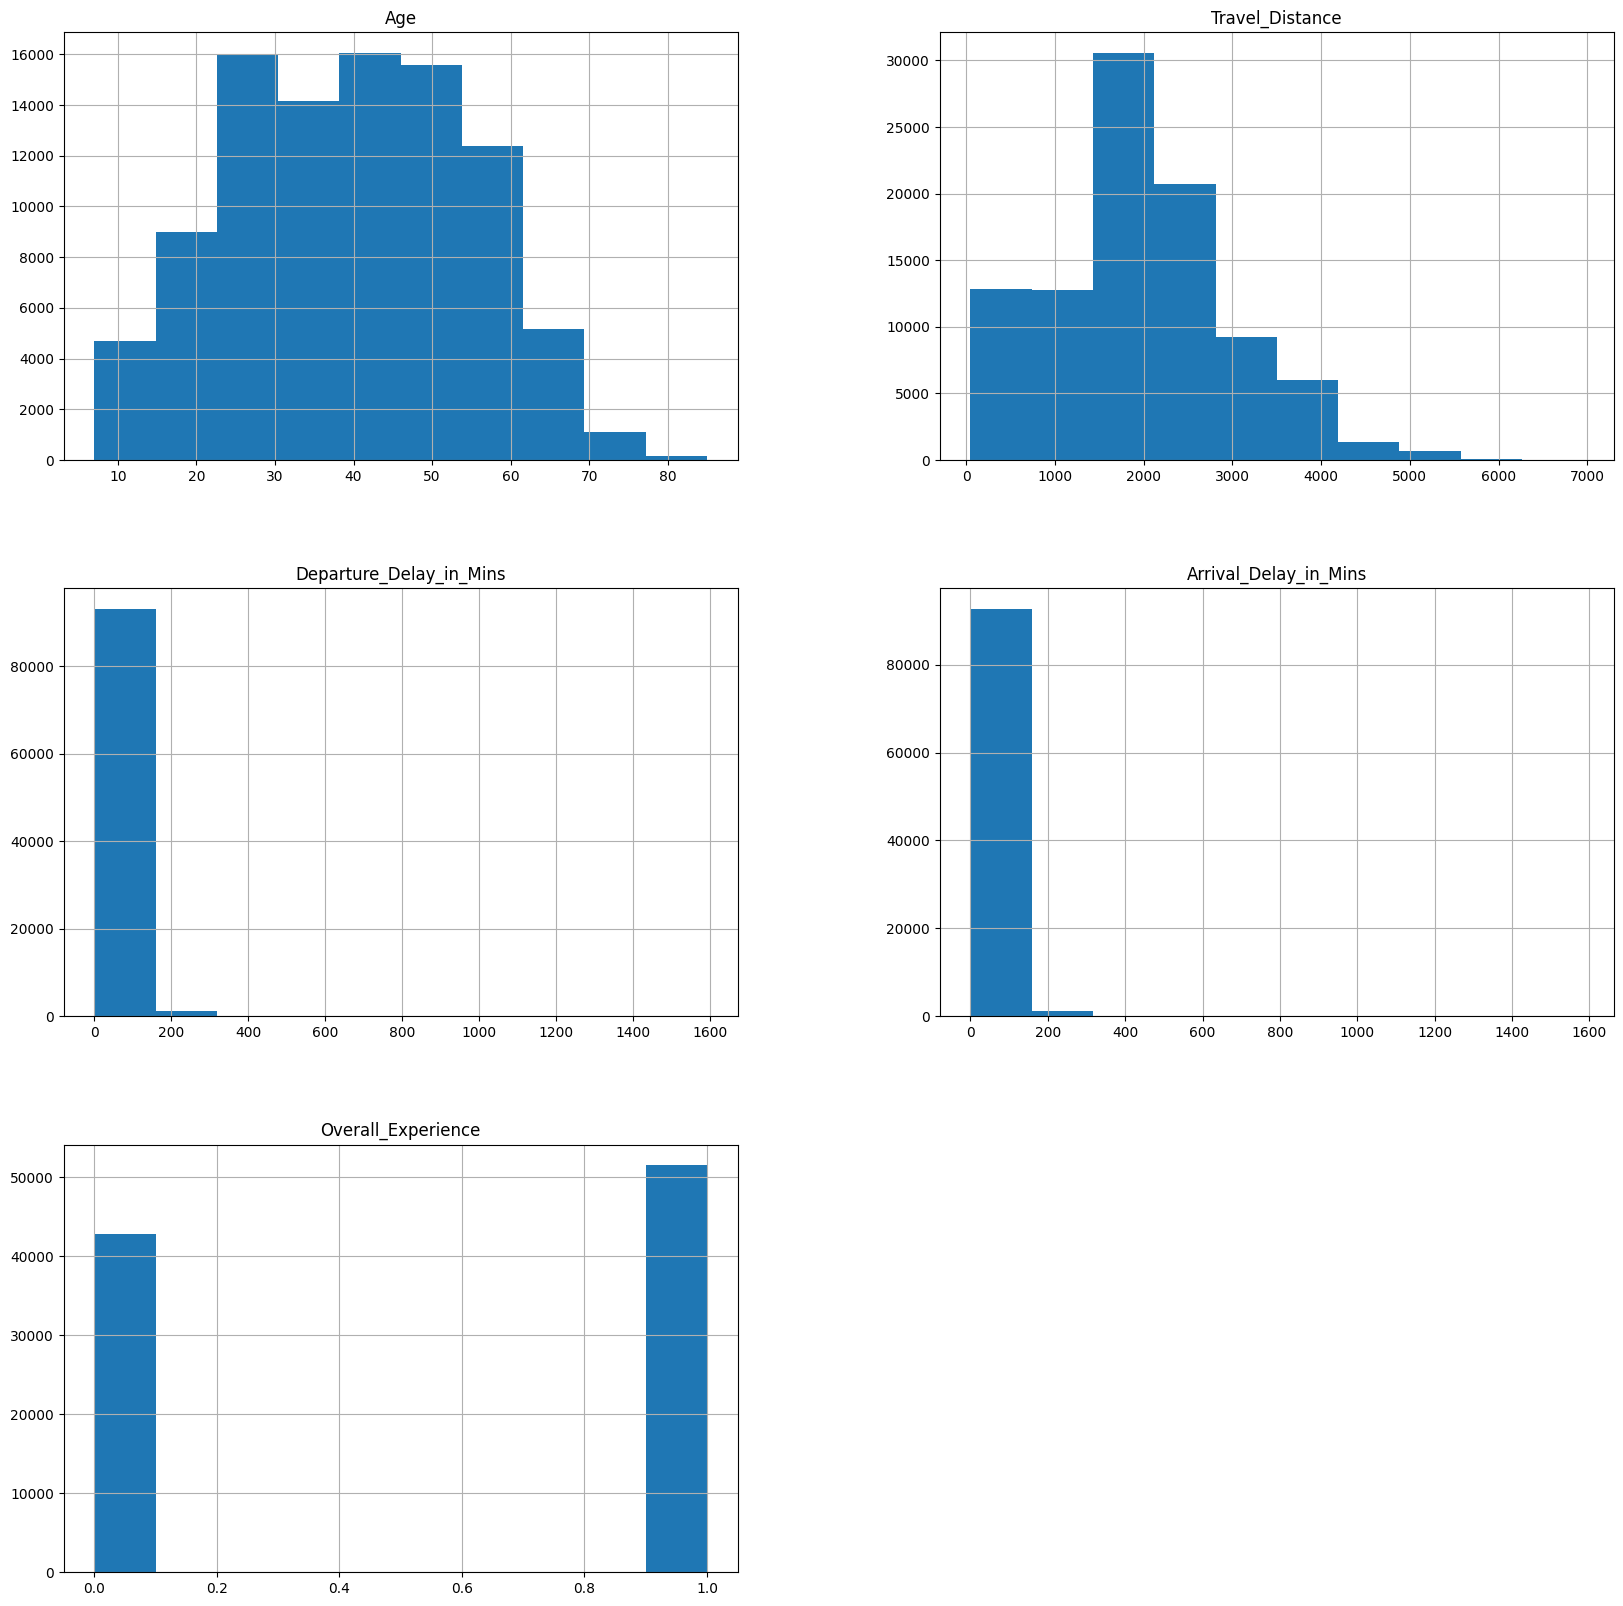

In [10]:
dfMerged_train[num_cols].hist(figsize=(20,20))
plt.show()

- Delays are right skewed,
- Age distribution near normal
- Satisfaction is near 50%,50% (let's flip a coin...)
- Light right skewness to travel distance


In [11]:
for i in cat_cols:
      print(dfMerged_train[i].value_counts(normalize=True))
      print('*'*48)

Female    0.507041
Male      0.492959
Name: Gender, dtype: float64
************************************************
Loyal Customer       0.817332
Disloyal Customer    0.182668
Name: Customer_Type, dtype: float64
************************************************
Business Travel    0.688373
Personal Travel    0.311627
Name: Type_Travel, dtype: float64
************************************************
Eco         0.522807
Business    0.477193
Name: Travel_Class, dtype: float64
************************************************
Acceptable           0.224326
Needs Improvement    0.222079
Good                 0.218357
Poor                 0.160998
Excellent            0.137524
Extremely Poor       0.036716
Name: Seat_Comfort, dtype: float64
************************************************
Green Car    0.502601
Ordinary     0.497399
Name: Seat_Class, dtype: float64
************************************************
Good                 0.229072
Excellent            0.206954
Acceptable           0.1

Looks like all ratings type variable follow a similar distribution.

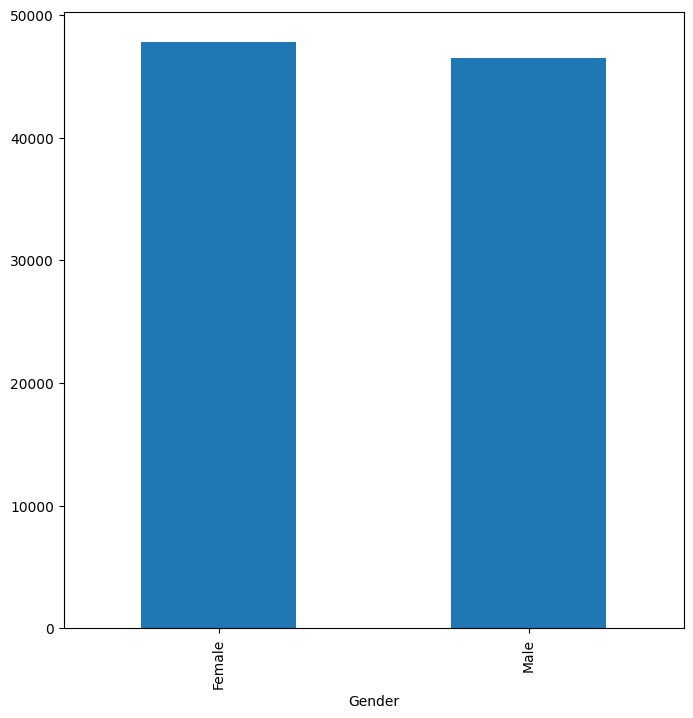

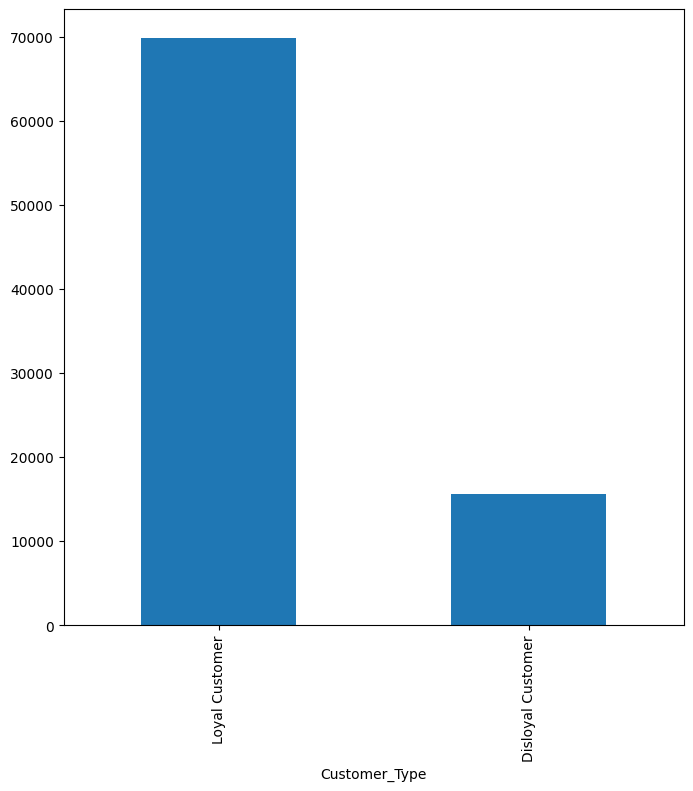

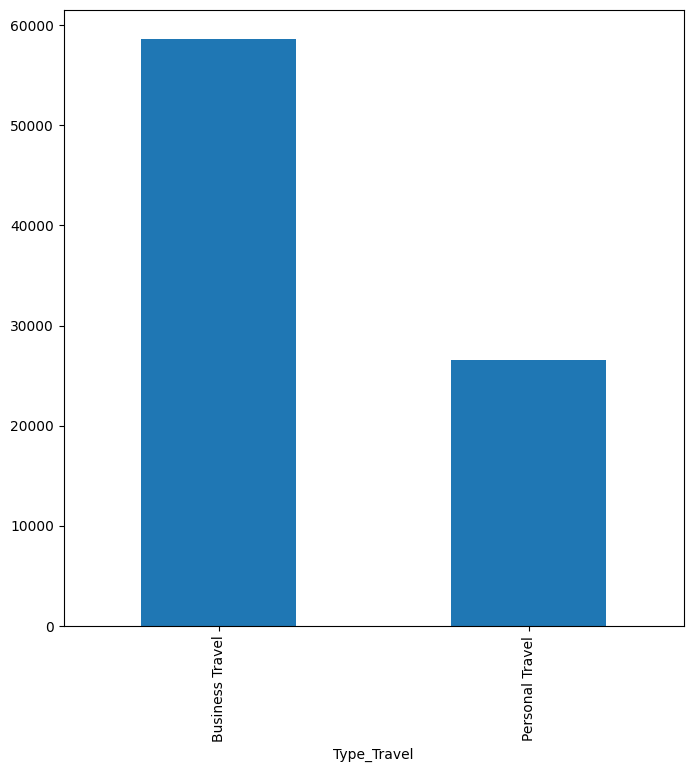

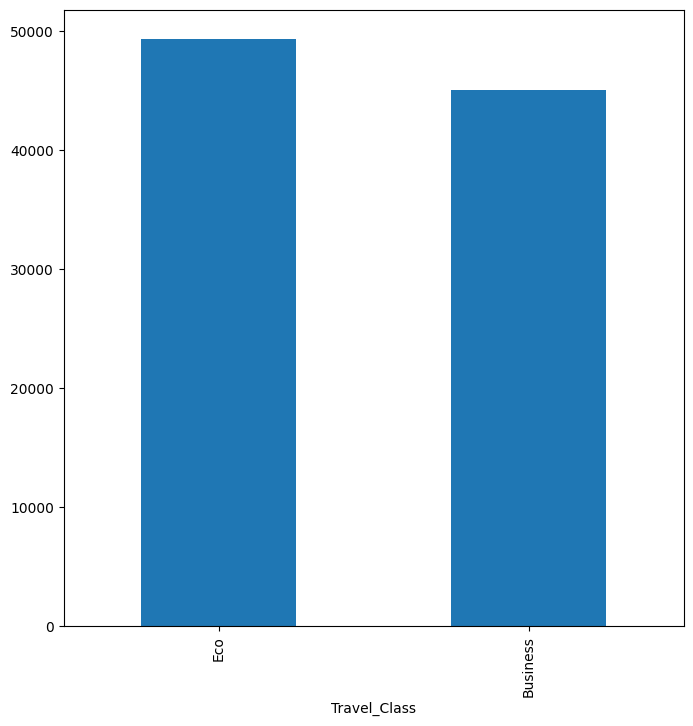

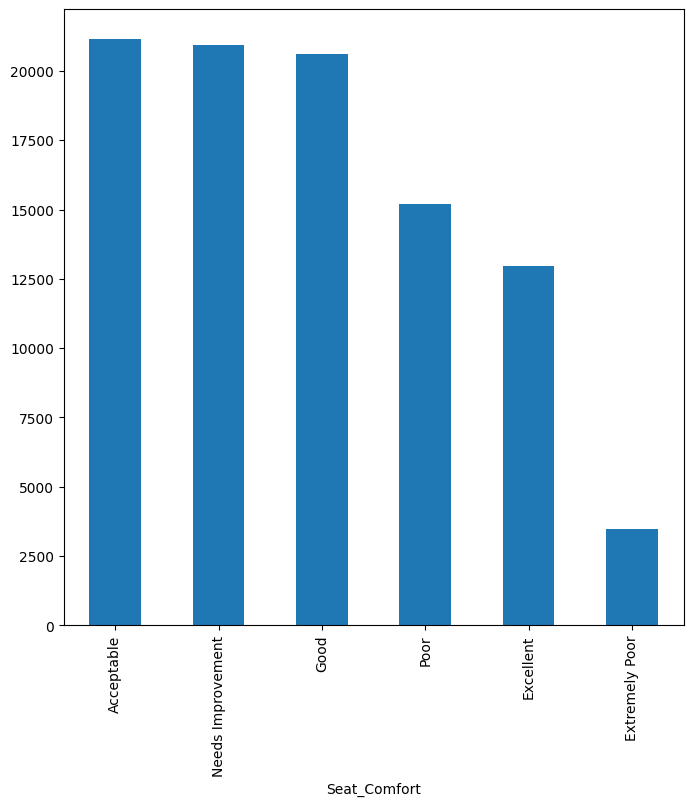

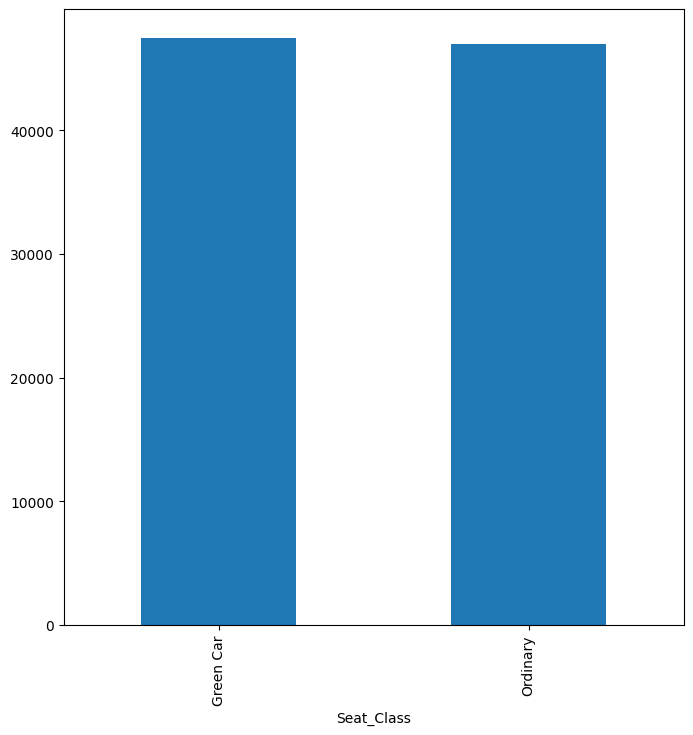

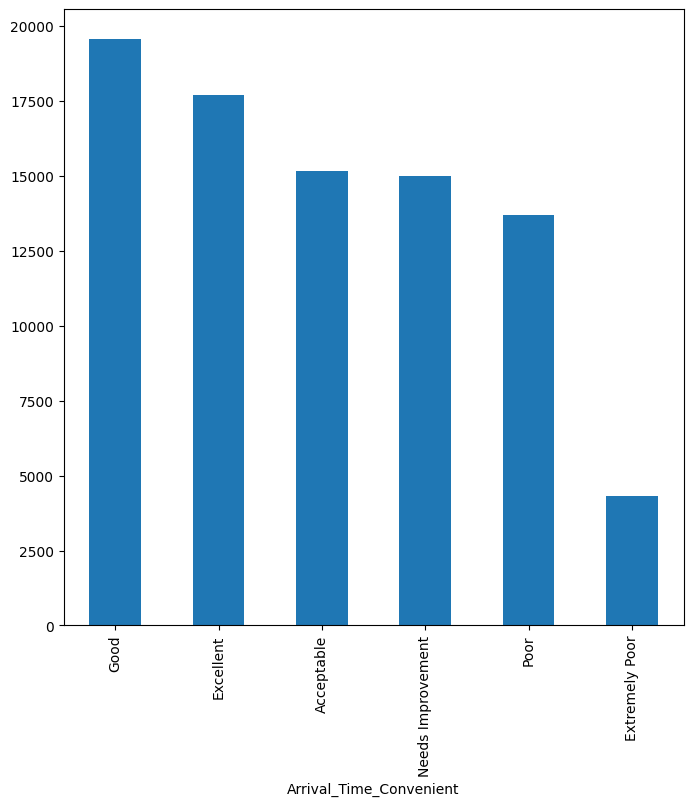

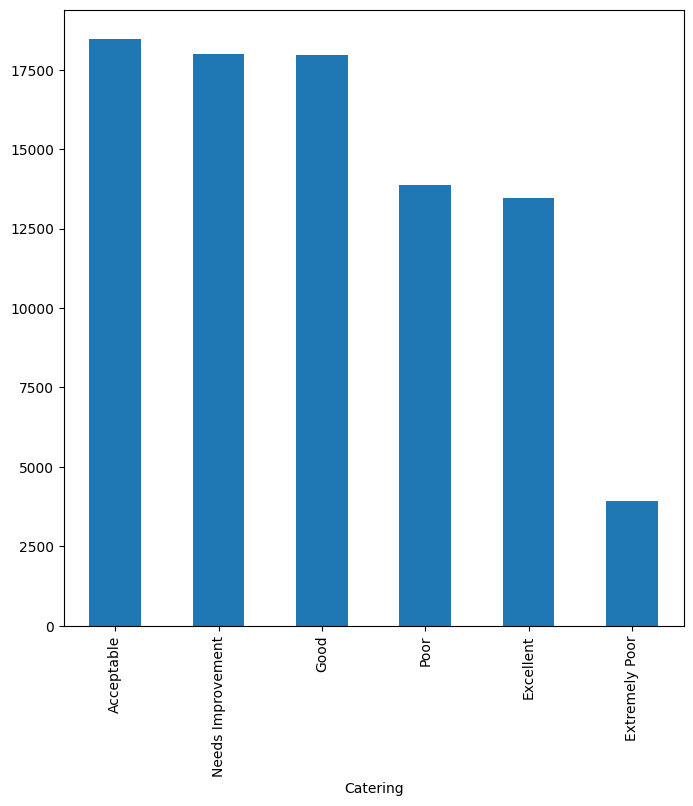

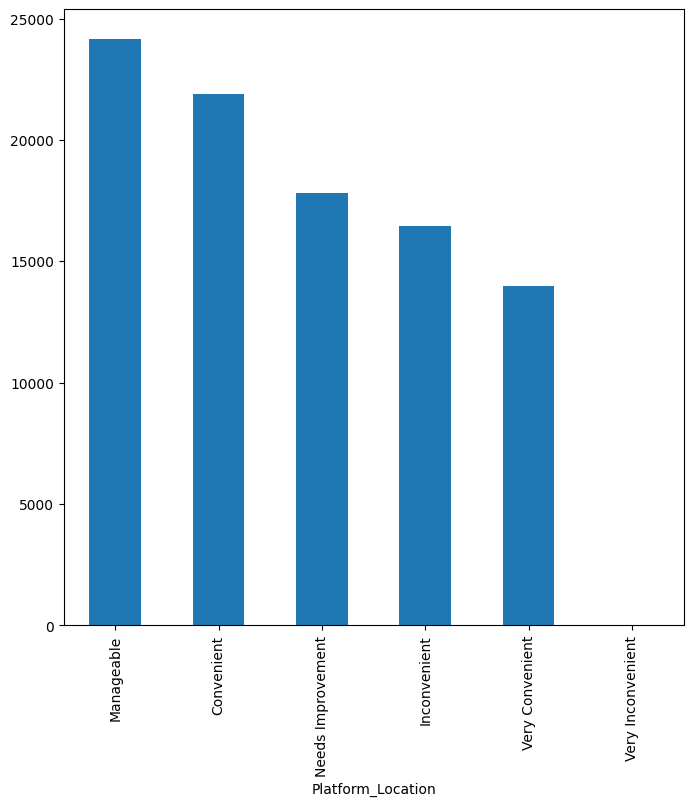

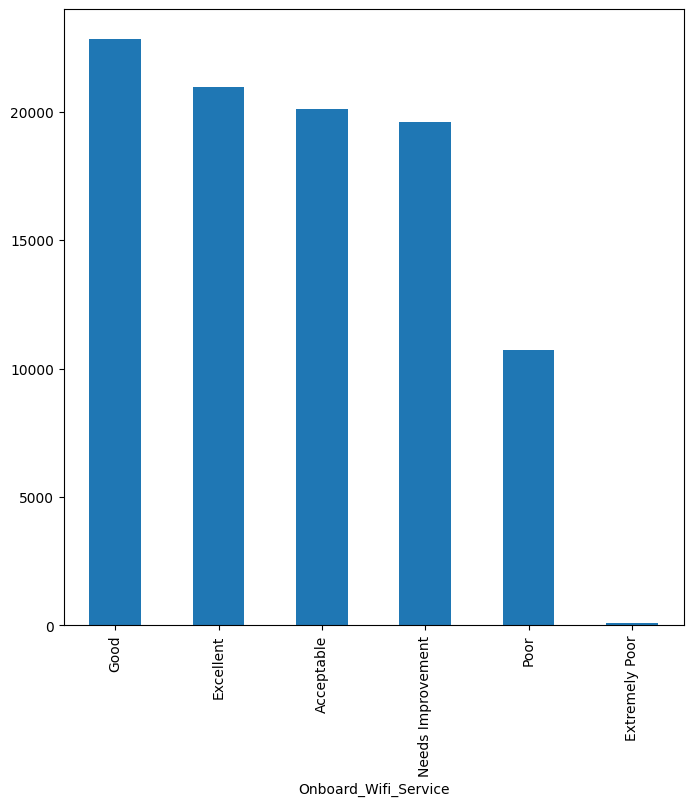

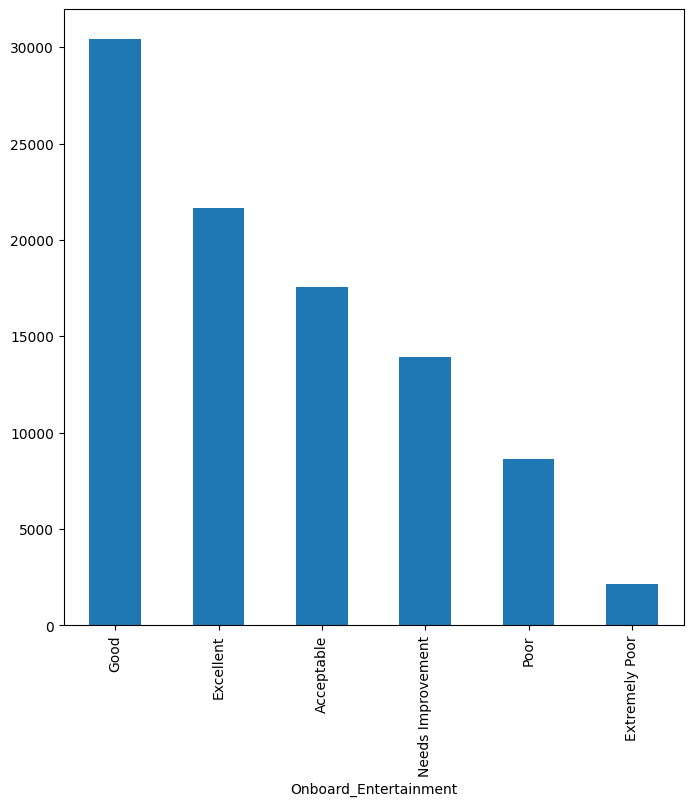

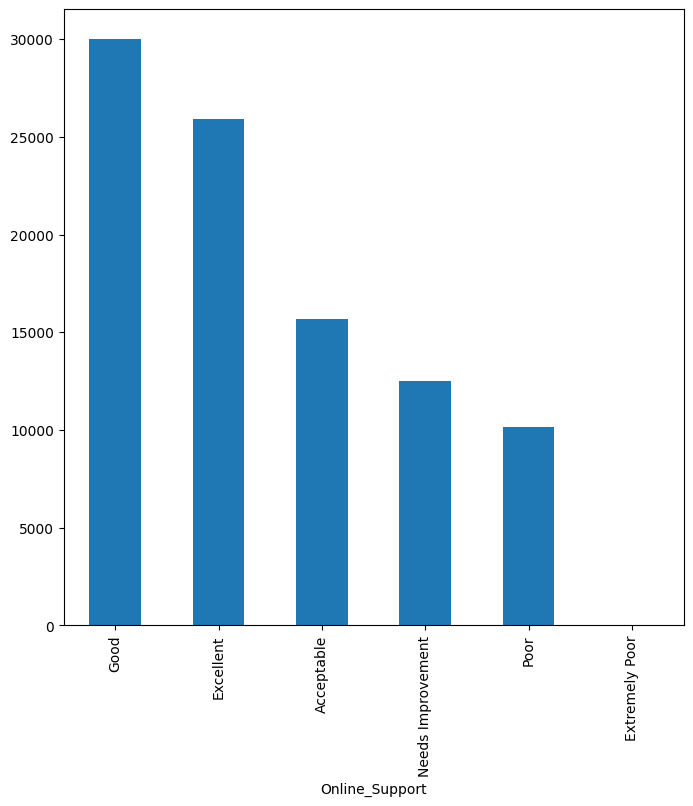

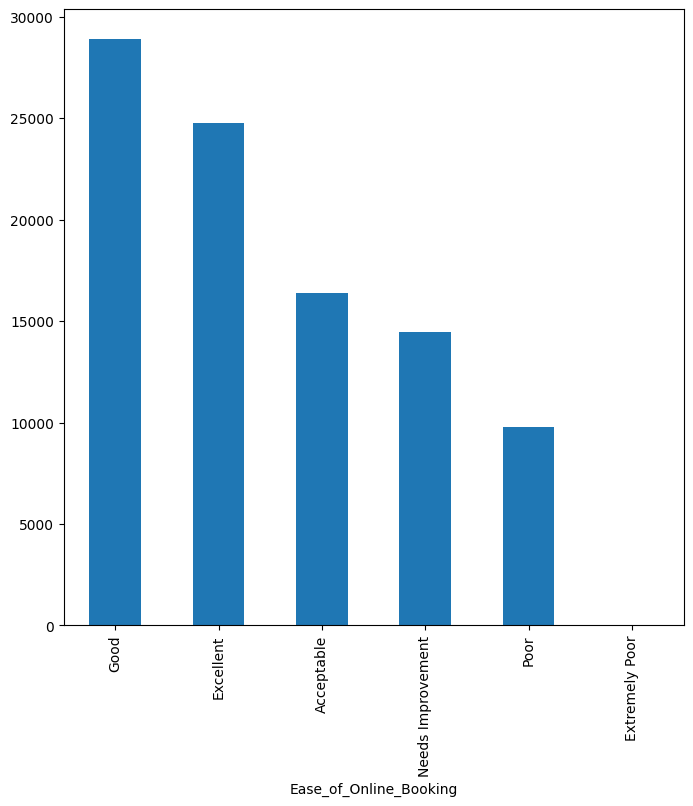

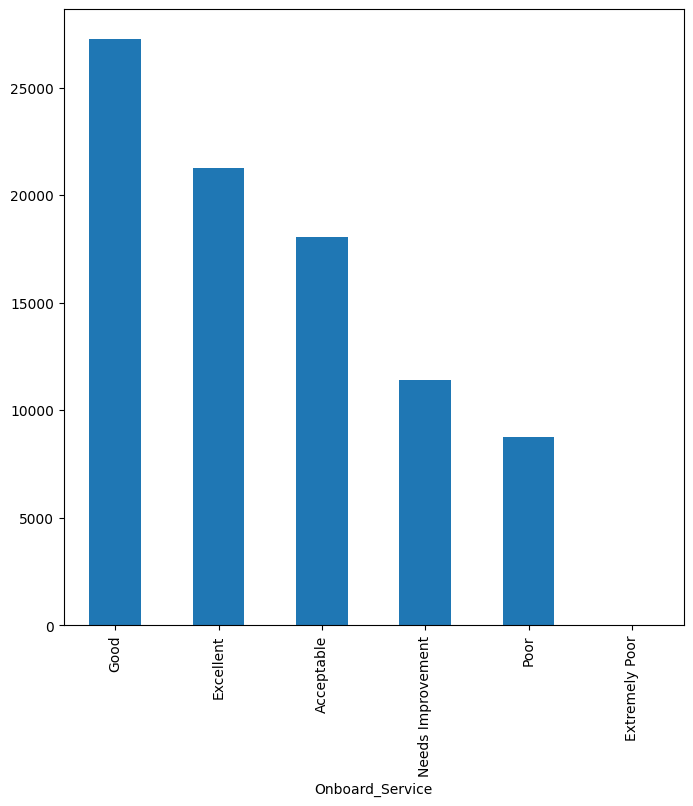

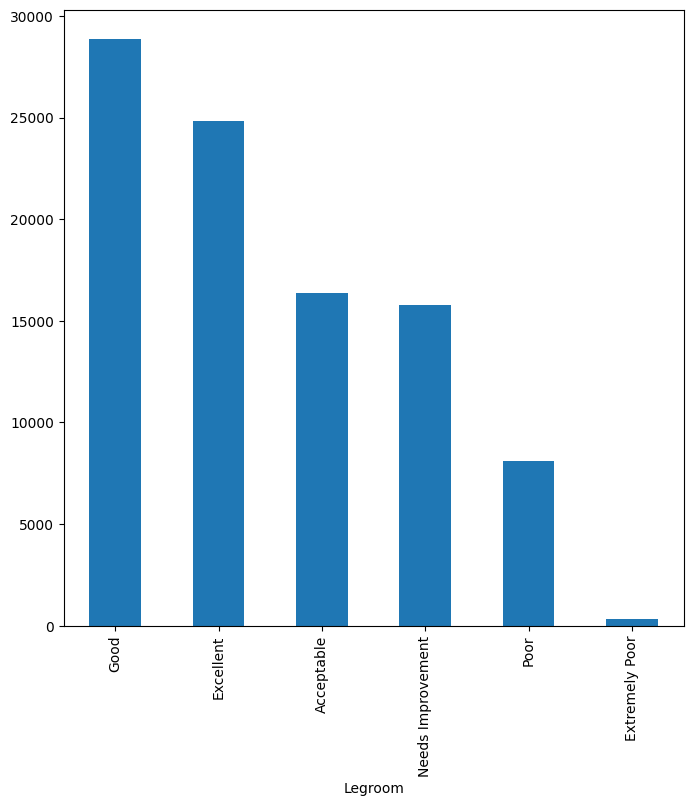

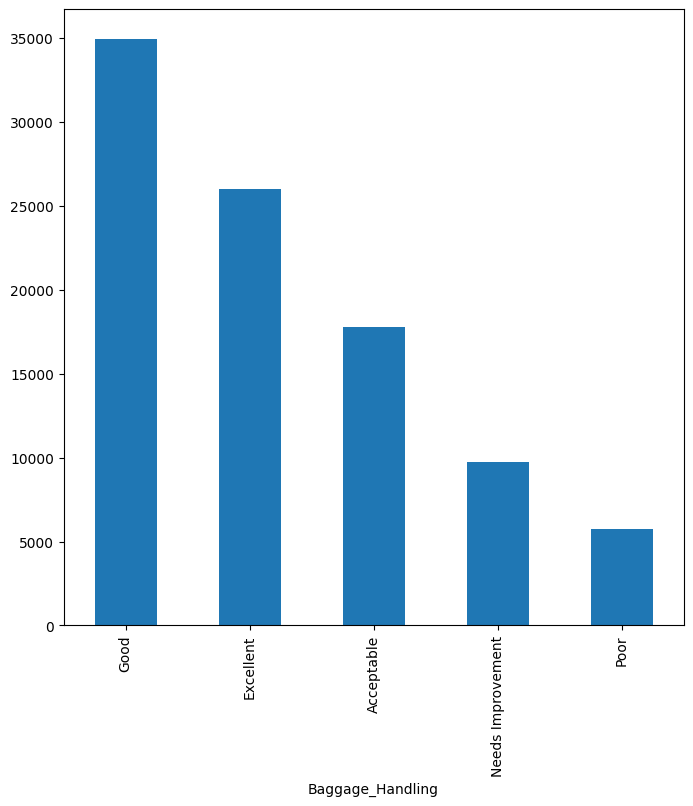

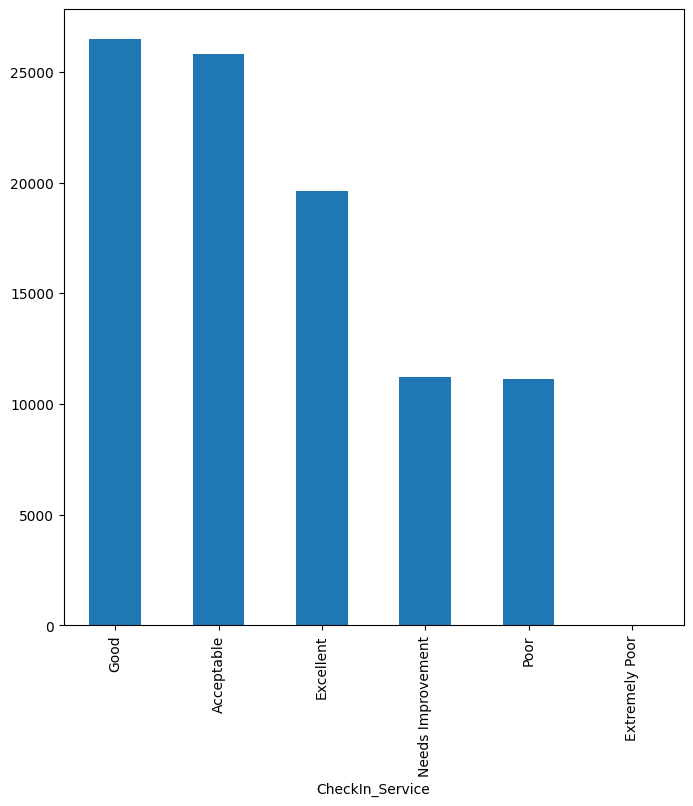

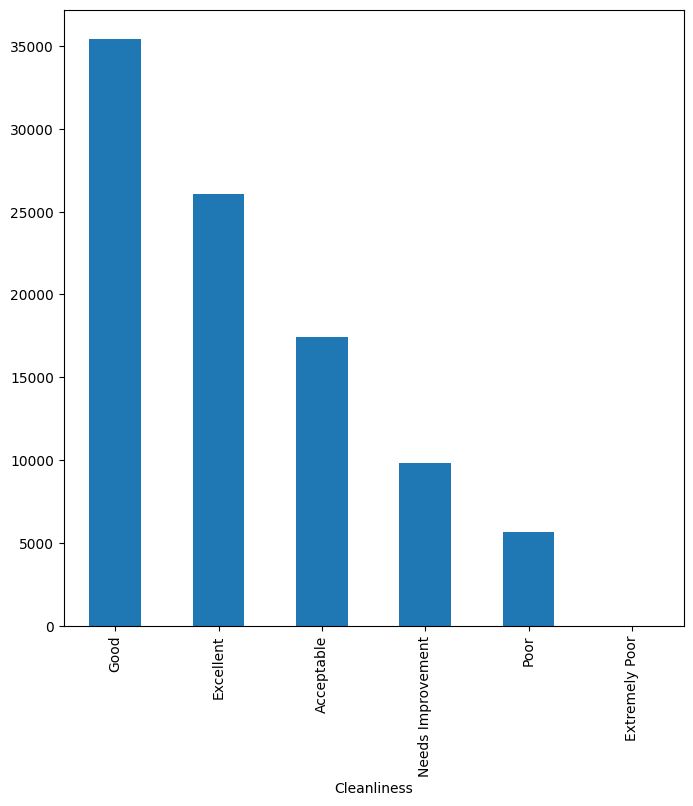

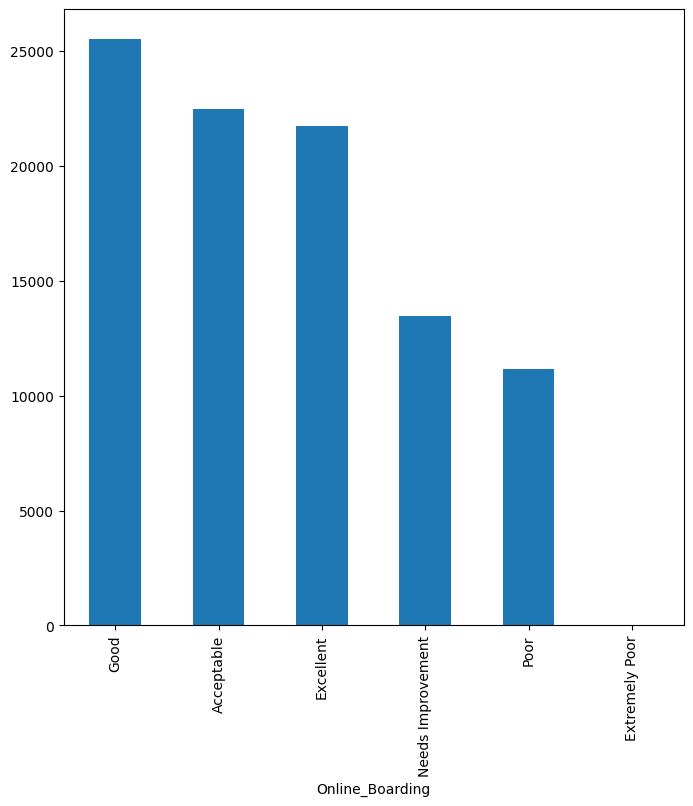

In [12]:
for i in cat_cols:
      if i!='Overall_Experience':
            dfMerged_train[i].value_counts().plot(kind='bar',figsize=(8,8),stacked=True)
            plt.xlabel(i)
            plt.show()

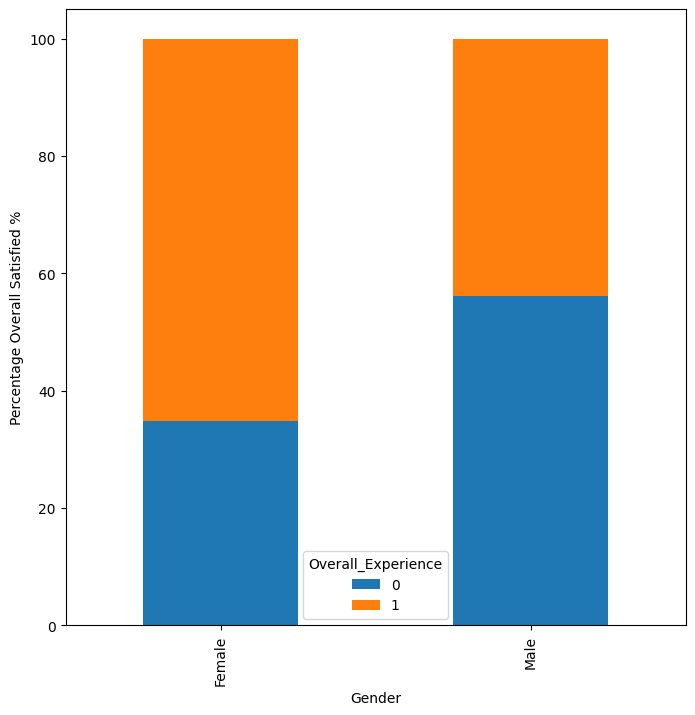

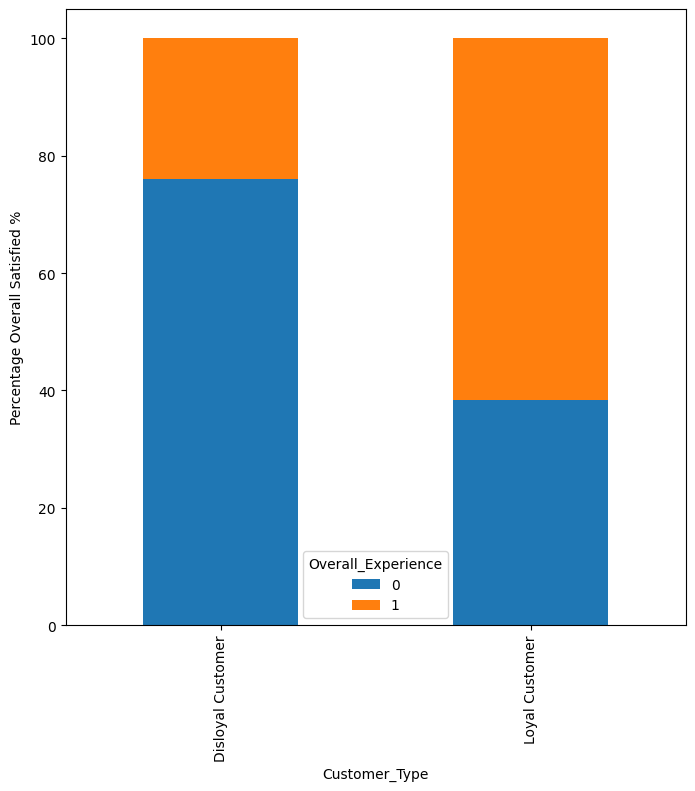

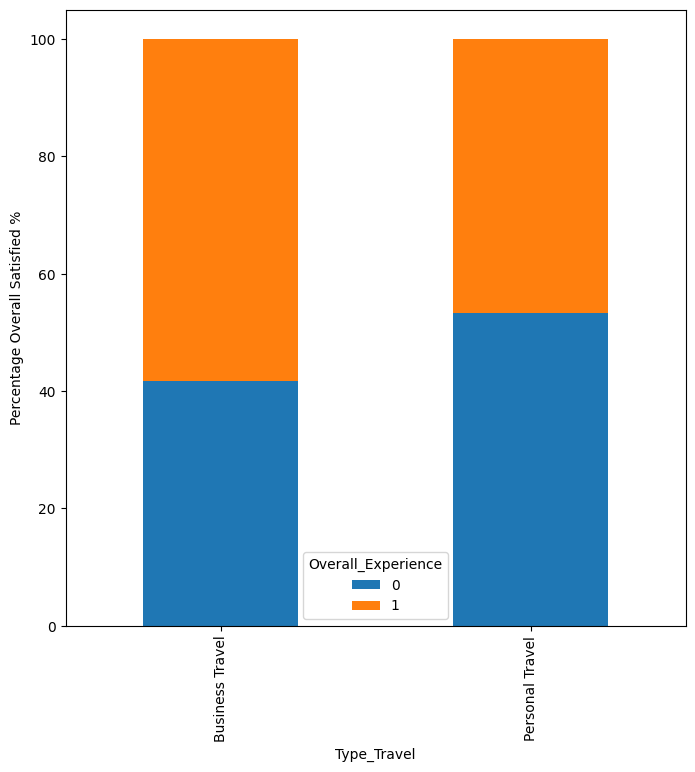

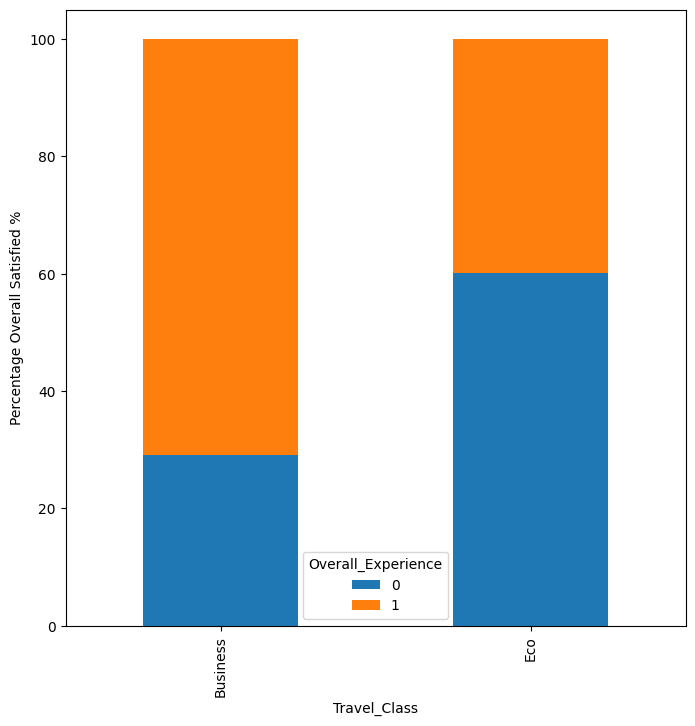

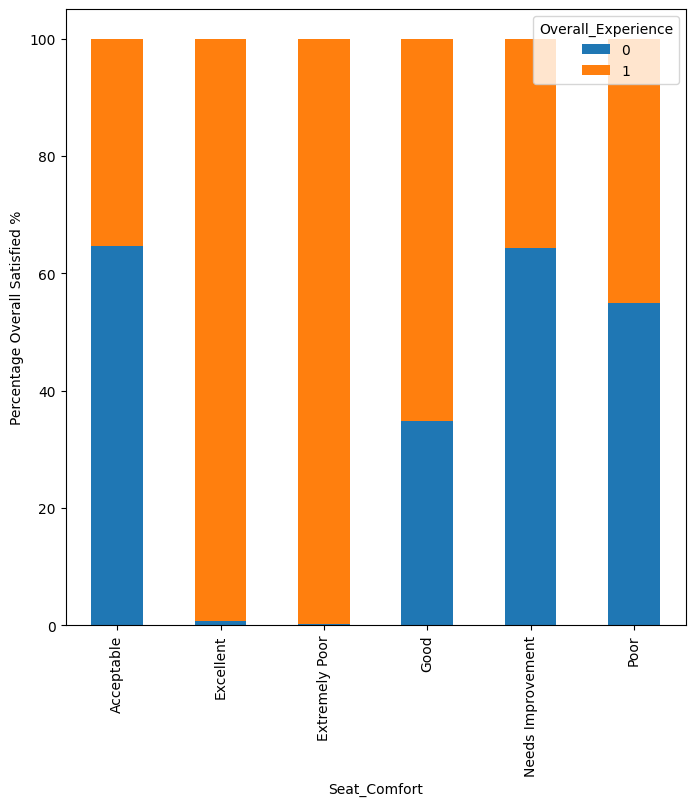

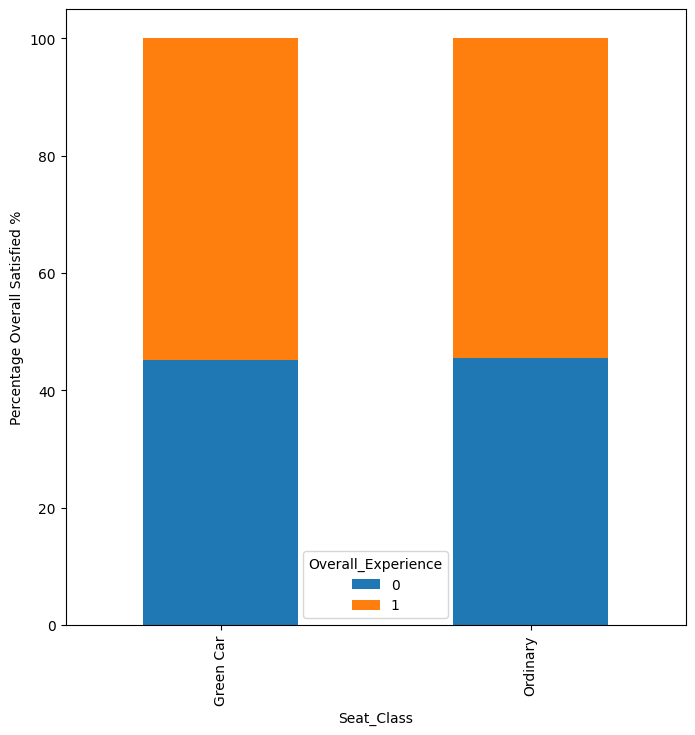

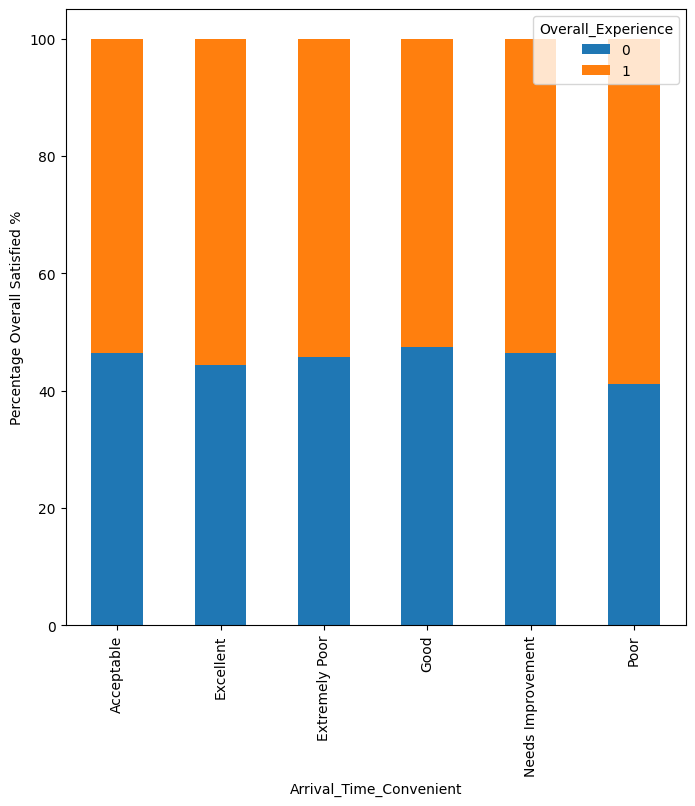

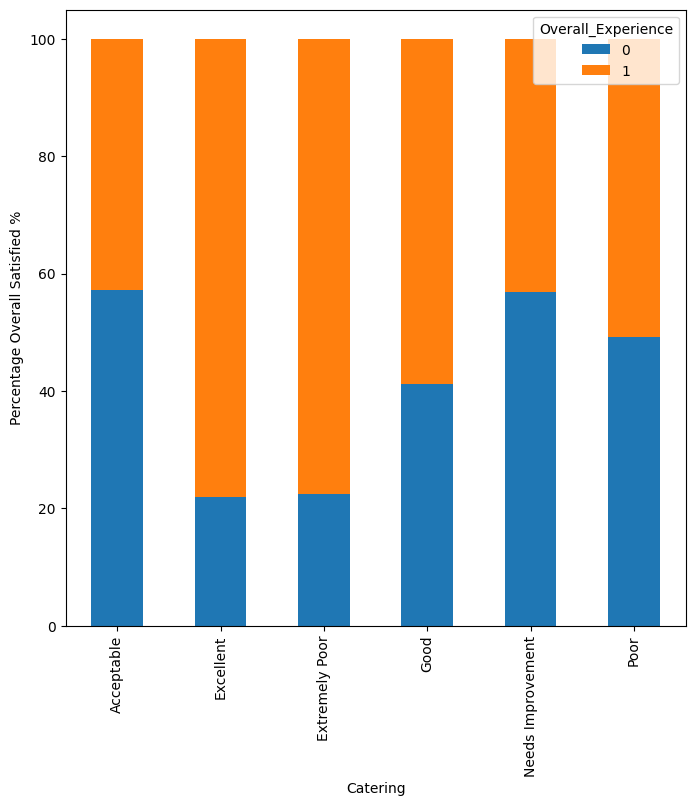

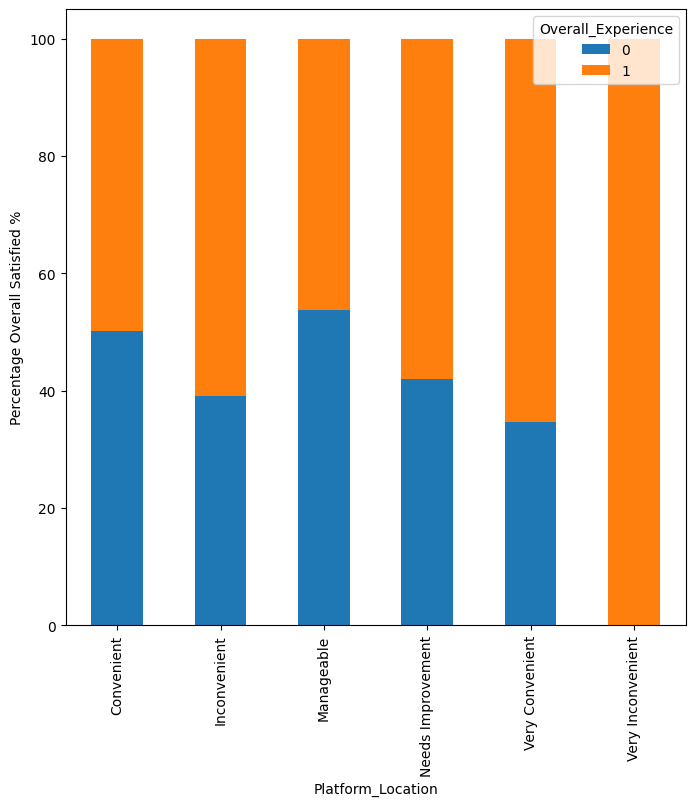

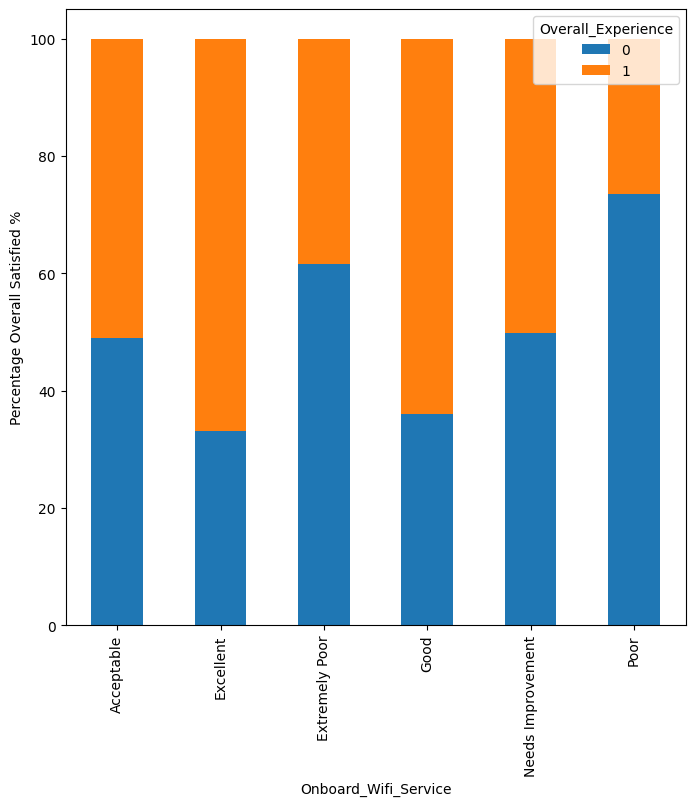

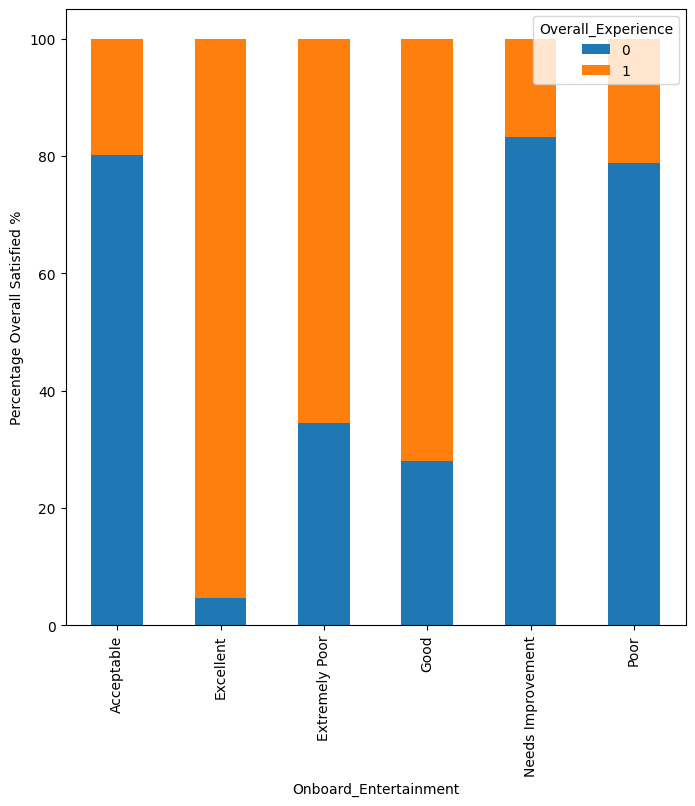

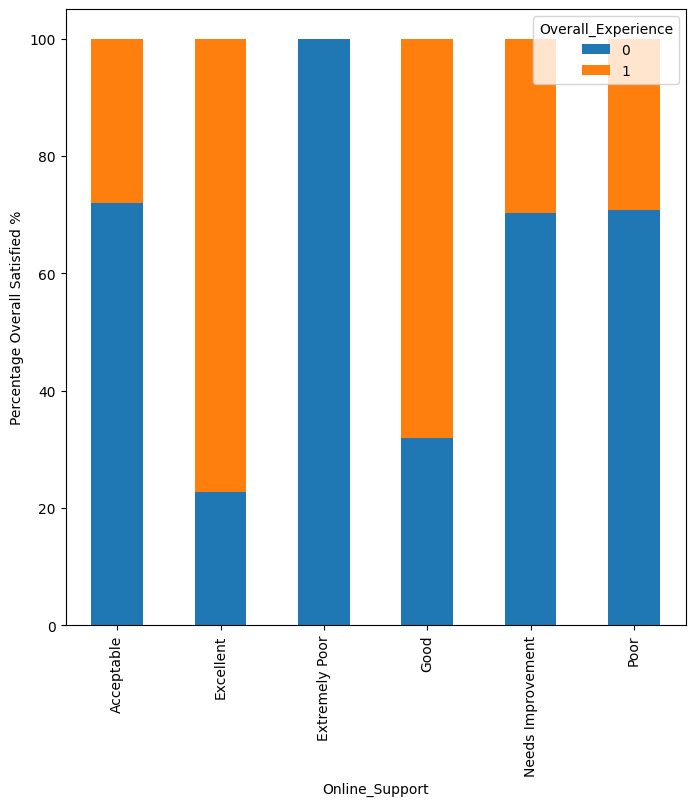

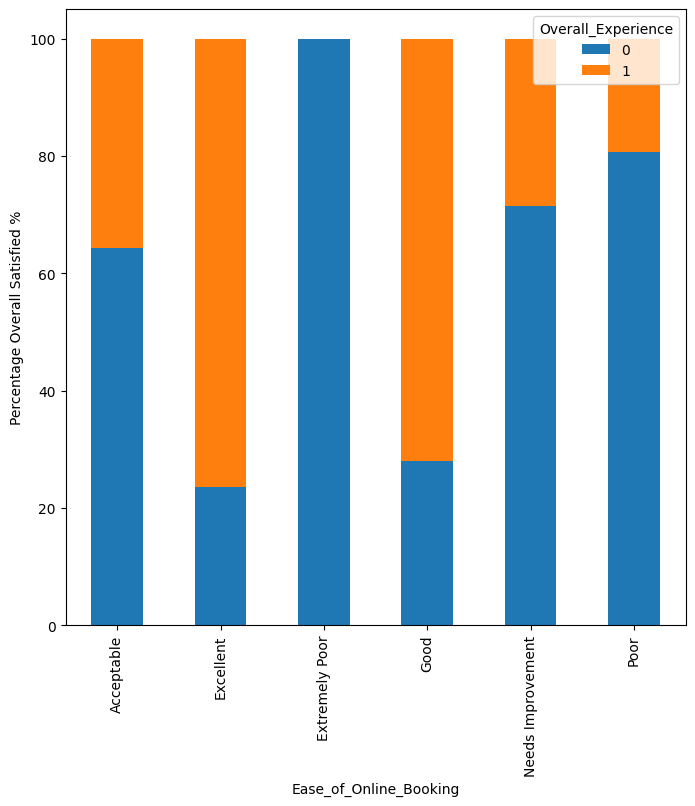

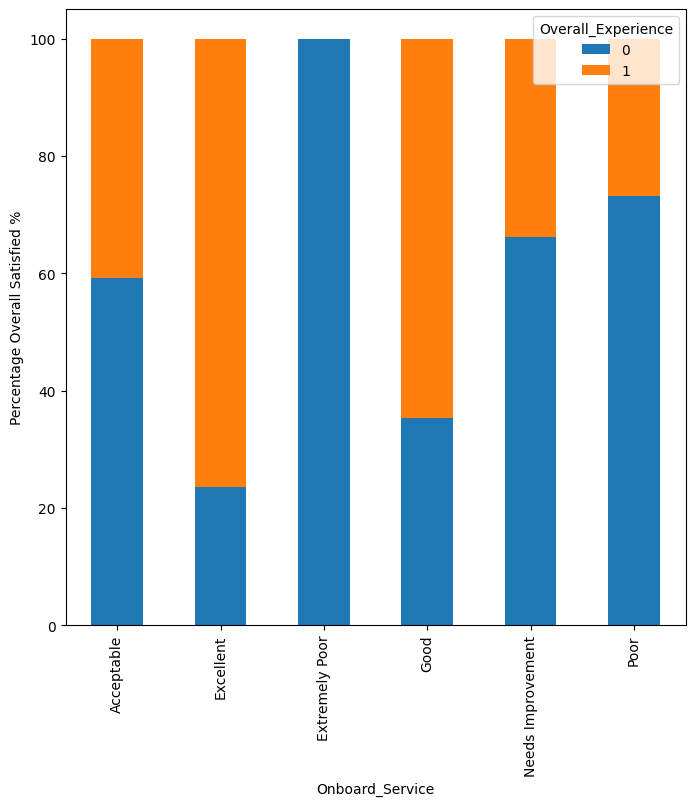

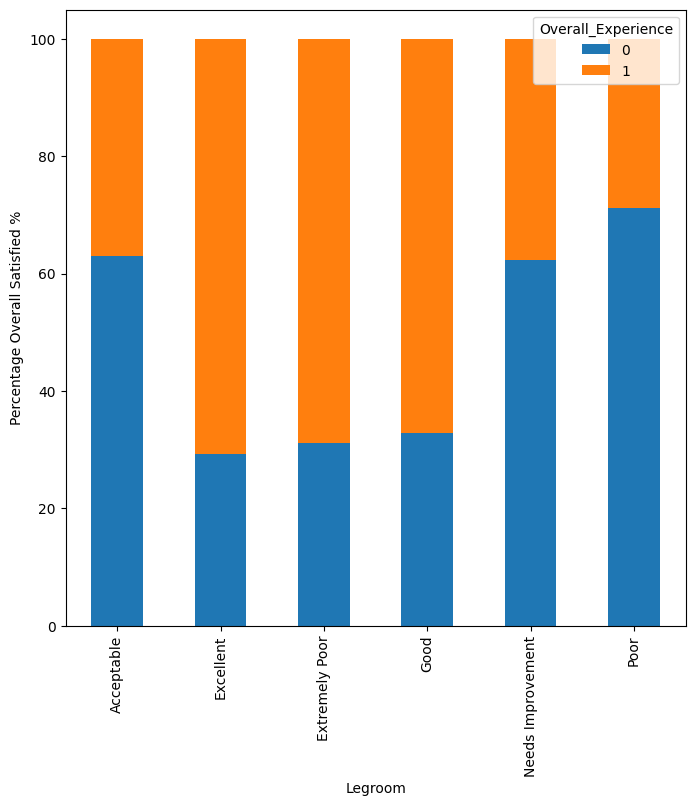

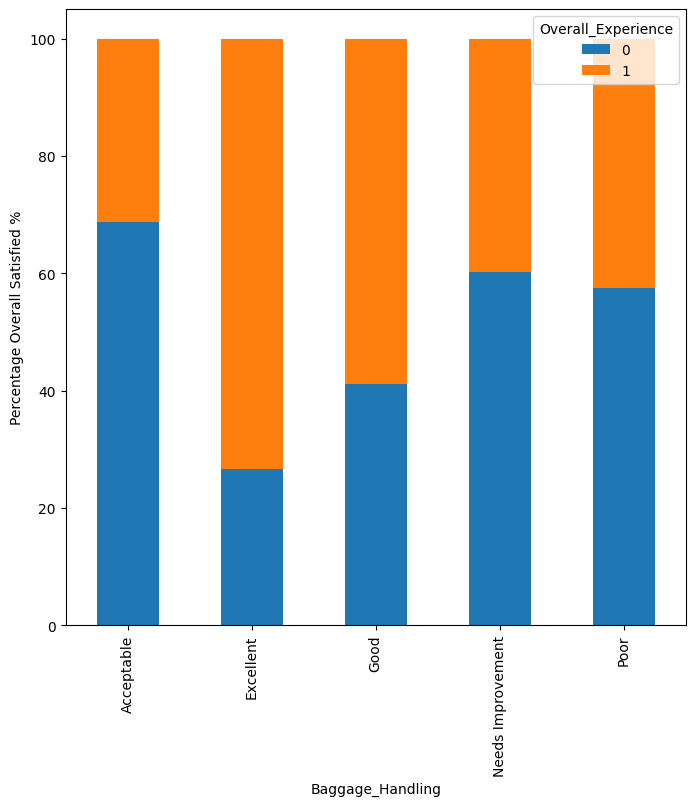

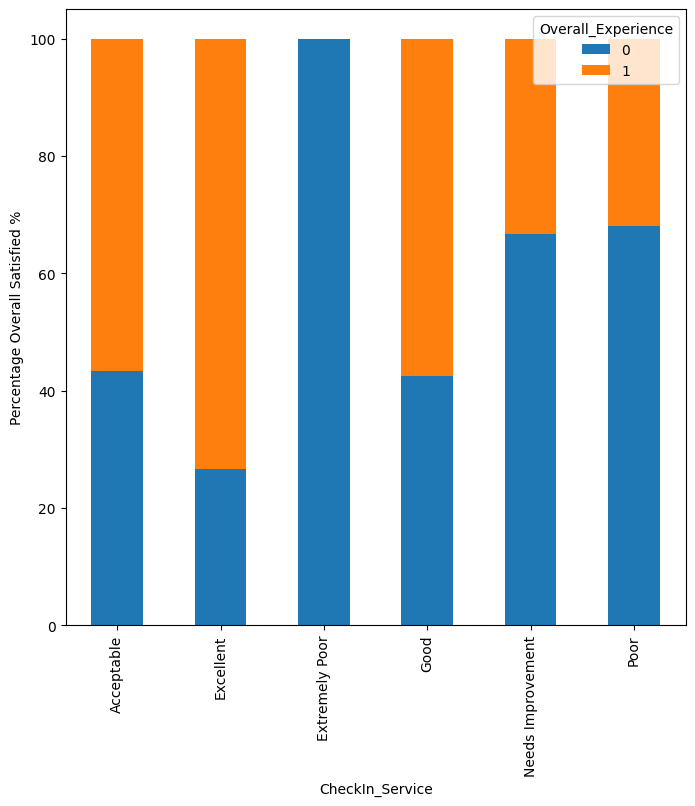

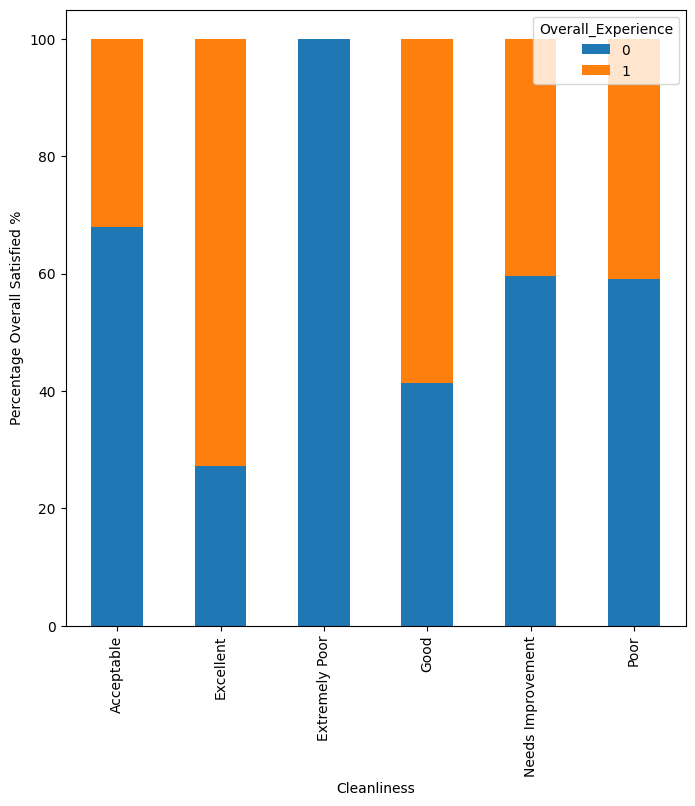

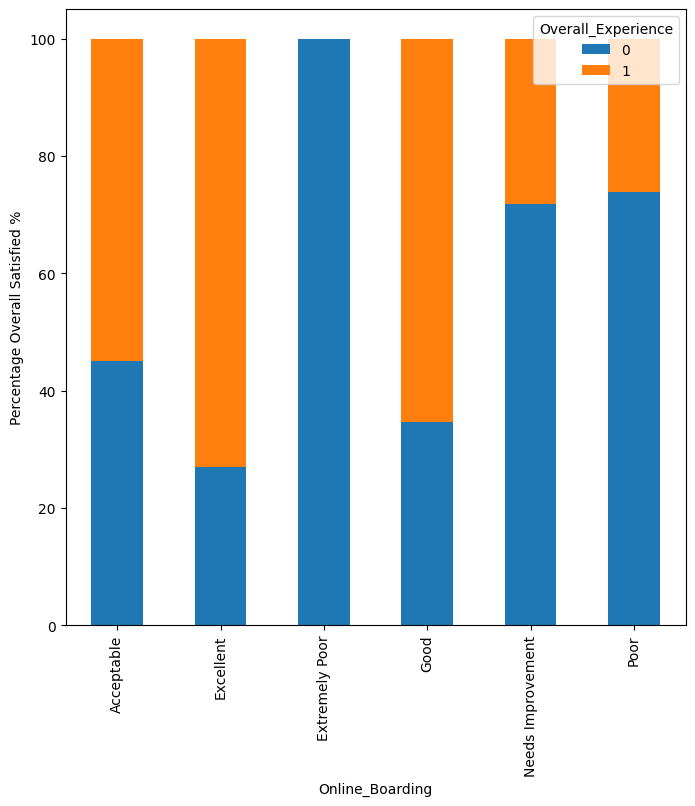

In [13]:
for i in cat_cols:
      if i!='Overall_Experience':
            (pd.crosstab(dfMerged_train[i],dfMerged_train['Overall_Experience'],normalize='index')*100).plot(kind='bar',figsize=(8,8),stacked=True)
            plt.ylabel('Percentage Overall Satisfied %')

In [14]:
dfMerged_train.groupby(['Overall_Experience'])[num_cols].mean()

,Age,Travel_Distance,Departure_Delay_in_Mins,Arrival_Delay_in_Mins,Overall_Experience
Overall_Experience,,,,,
0,37.49018,2025.826088,17.738600,18.392374,0.0
1,41.01968,1939.962650,12.083107,12.196763,1.0


On average, passengers with a positive overall experience are four years older, travel less distance and experience less delays than passengers with a negative overall experience.

<AxesSubplot: >

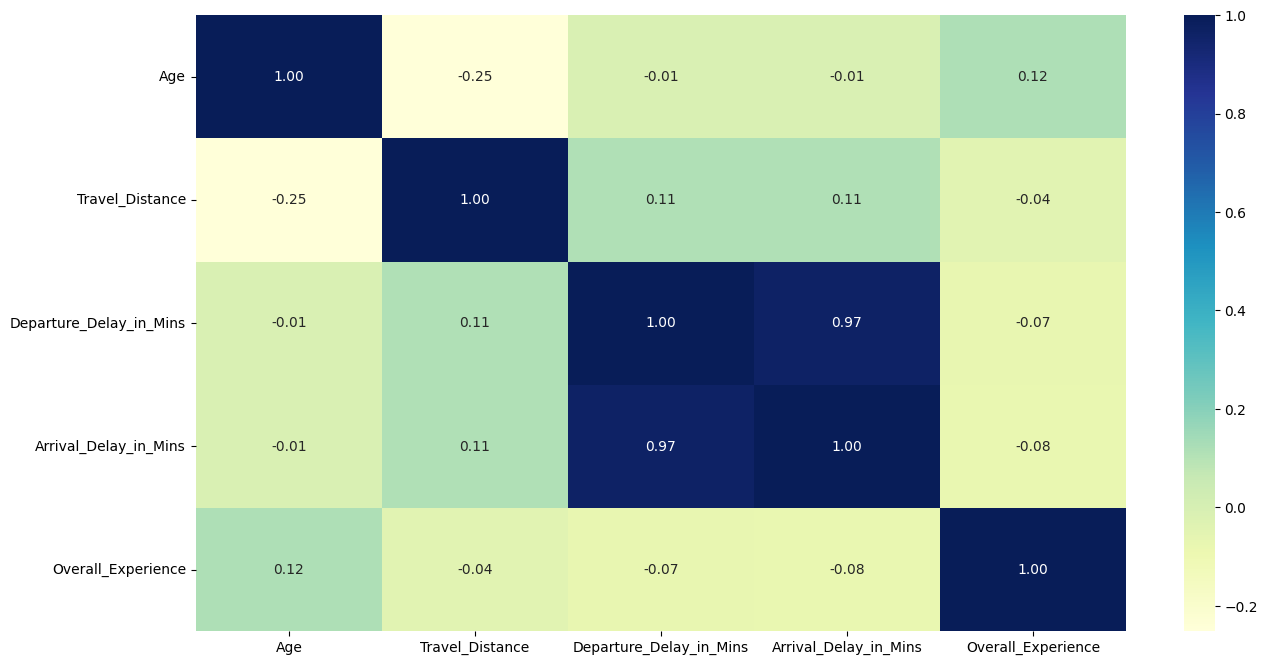

In [15]:
plt.figure(figsize=(15,8))
sns.heatmap(dfMerged_train[num_cols].corr(),annot=True, fmt='0.2f', cmap='YlGnBu')

Not much new information here.  Let's try to encode our categoricals and see where this gets us.

- As a first pass we will encode all values including nulls.  Since there could be valid reasons for them not to be collected (i.e. some hidden relationship).  Arrival and Departures delays will be imputed to the median since they are highly skewed.  The survey questions like Online_support and stuff we can see later on since these are low frequency.  We could likely just delete them altogether.

In [17]:
dfCopy_train = dfMerged_train.copy(deep=True)
dfCopy_test = dfMerged_test.copy(deep=True)
#We will need to review this and see if we want to assign values to labels manually.

#These are for Seat_comfort, Arrival_time_convenient, Catering, Onboardwifi_service,Onboard_entertainment,Online_support, 
# Onlinebooking_Ease, Onboard_service, Leg_room,Baggage_handling, Checkin_service,  Cleanliness,Online_boarding 
survey_dict =  {'Extremely Poor': 0, 'Poor':1, 'Needs Improvement':2, 'Acceptable':3, 'Good':4, 'Excellent':5}

#This one is for the platform_location
#platform_dict = {'Very Inconvenient':0, 'Inconvenient':1, 'Need Improvement':2, 'Manageable':3, 'Convenient':4, 'Very Convenient':5  }

#Seat types:
seats_dict = {'Ordinary':0,'Green Car':1}

#Type Travel:
traveltype_dict = {'Personal Travel':0, 'Business Travel':1}

#CustomerType
custtype_dict = {'Disloyal Customer':0,'Loyal Customer':1}

dfCopy_train['Gender'] = dfCopy_train['Gender'].map({'Female':0, 'Male': 1})
dfCopy_train['Seat_Comfort'] = dfCopy_train['Seat_Comfort'].map(survey_dict)
dfCopy_train['Arrival_Time_Convenient'] = dfCopy_train['Arrival_Time_Convenient'].map(survey_dict)
dfCopy_train['Catering'] = dfCopy_train['Catering'].map(survey_dict)
dfCopy_train['Onboard_Wifi_Service'] = dfCopy_train['Onboard_Wifi_Service'].map(survey_dict)
dfCopy_train['Onboard_Entertainment'] = dfCopy_train['Onboard_Entertainment'].map(survey_dict)
dfCopy_train['Online_Support'] = dfCopy_train['Online_Support'].map(survey_dict)
dfCopy_train['Ease_of_Online_Booking'] = dfCopy_train['Ease_of_Online_Booking'].map(survey_dict)
dfCopy_train['Onboard_Service'] = dfCopy_train['Onboard_Service'].map(survey_dict)
dfCopy_train['Legroom'] = dfCopy_train['Legroom'].map(survey_dict)
dfCopy_train['Baggage_Handling'] = dfCopy_train['Baggage_Handling'].map(survey_dict)
dfCopy_train['CheckIn_Service'] = dfCopy_train['CheckIn_Service'].map(survey_dict)
dfCopy_train['Cleanliness'] = dfCopy_train['Cleanliness'].map(survey_dict)
dfCopy_train['Online_Boarding'] = dfCopy_train['Online_Boarding'].map(survey_dict)
dfCopy_train['Travel_Class'] = dfCopy_train['Travel_Class'].map({'Eco':0, 'Business': 1})

dfCopy_train['Platform_Location'] = dfCopy_train.Platform_Location.map({'Very Inconvenient':0, 'Inconvenient':1, 'Needs Improvement':2, 'Manageable':3, 'Convenient':4, 'Very Convenient':5  })

dfCopy_train['Seat_Class'] = dfCopy_train['Seat_Class'].map(seats_dict)
dfCopy_train['Type_Travel'] = dfCopy_train['Type_Travel'].map(traveltype_dict)
dfCopy_train['Customer_Type'] = dfCopy_train['Customer_Type'].map(custtype_dict)

#Same but for the test set this time.

dfCopy_test['Gender'] = dfCopy_test['Gender'].map({'Female':0, 'Male': 1})
dfCopy_test['Seat_Comfort'] = dfCopy_test['Seat_Comfort'].map(survey_dict)
dfCopy_test['Arrival_Time_Convenient'] = dfCopy_test['Arrival_Time_Convenient'].map(survey_dict)
dfCopy_test['Catering'] = dfCopy_test['Catering'].map(survey_dict)
dfCopy_test['Onboard_Wifi_Service'] = dfCopy_test['Onboard_Wifi_Service'].map(survey_dict)
dfCopy_test['Onboard_Entertainment'] = dfCopy_test['Onboard_Entertainment'].map(survey_dict)
dfCopy_test['Online_Support'] = dfCopy_test['Online_Support'].map(survey_dict)
dfCopy_test['Ease_of_Online_Booking'] = dfCopy_test['Ease_of_Online_Booking'].map(survey_dict)
dfCopy_test['Onboard_Service'] = dfCopy_test['Onboard_Service'].map(survey_dict)
dfCopy_test['Legroom'] = dfCopy_test['Legroom'].map(survey_dict)
dfCopy_test['Baggage_Handling'] = dfCopy_test['Baggage_Handling'].map(survey_dict)
dfCopy_test['CheckIn_Service'] = dfCopy_test['CheckIn_Service'].map(survey_dict)
dfCopy_test['Cleanliness'] = dfCopy_test['Cleanliness'].map(survey_dict)
dfCopy_test['Online_Boarding'] = dfCopy_test['Online_Boarding'].map(survey_dict)
dfCopy_test['Travel_Class'] = dfCopy_test['Travel_Class'].map({'Eco':0, 'Business': 1})

dfCopy_test['Platform_Location'] = dfCopy_test.Platform_Location.map({'Very Inconvenient':0, 'Inconvenient':1, 'Needs Improvement':2, 'Manageable':3, 'Convenient':4, 'Very Convenient':5  })

dfCopy_test['Seat_Class'] = dfCopy_test['Seat_Class'].map(seats_dict)
dfCopy_test['Type_Travel'] = dfCopy_test['Type_Travel'].map(traveltype_dict)
dfCopy_test['Customer_Type'] = dfCopy_test['Customer_Type'].map(custtype_dict)


#labelenc_cols = ['Customer_Type','Seat_Class','Travel_Class','Type_Travel','Gender',]
#dfCopy_train[labelenc_cols] = dfCopy_train[labelenc_cols].apply(LabelEncoder().fit_transform)

for i in dfCopy_train.columns:
      print(dfCopy_train[i].value_counts())
print (48*'-=')
for i in dfCopy_test.columns:
      print(dfCopy_test[i].value_counts())




0.0    47815
1.0    46487
Name: Gender, dtype: int64
1.0    69823
0.0    15605
Name: Customer_Type, dtype: int64
39.0    2688
25.0    2542
40.0    2333
44.0    2291
41.0    2248
        ... 
73.0      47
79.0      39
76.0      38
78.0      30
85.0      18
Name: Age, Length: 75, dtype: int64
1.0    58617
0.0    26536
Name: Type_Travel, dtype: int64
0    49342
1    45037
Name: Travel_Class, dtype: int64
1963    72
1789    68
1894    65
1639    65
1981    64
        ..
5028     1
4312     1
5267     1
4094     1
4156     1
Name: Travel_Distance, Length: 5210, dtype: int64
0.0      53339
1.0       2734
2.0       2096
3.0       1838
4.0       1641
         ...  
933.0        1
292.0        1
323.0        1
815.0        1
610.0        1
Name: Departure_Delay_in_Mins, Length: 437, dtype: int64
0.0      52915
1.0       1995
2.0       1899
3.0       1757
4.0       1713
         ...  
586.0        1
399.0        1
920.0        1
267.0        1
593.0        1
Name: Arrival_Delay_in_Mins, Length: 

<AxesSubplot: >

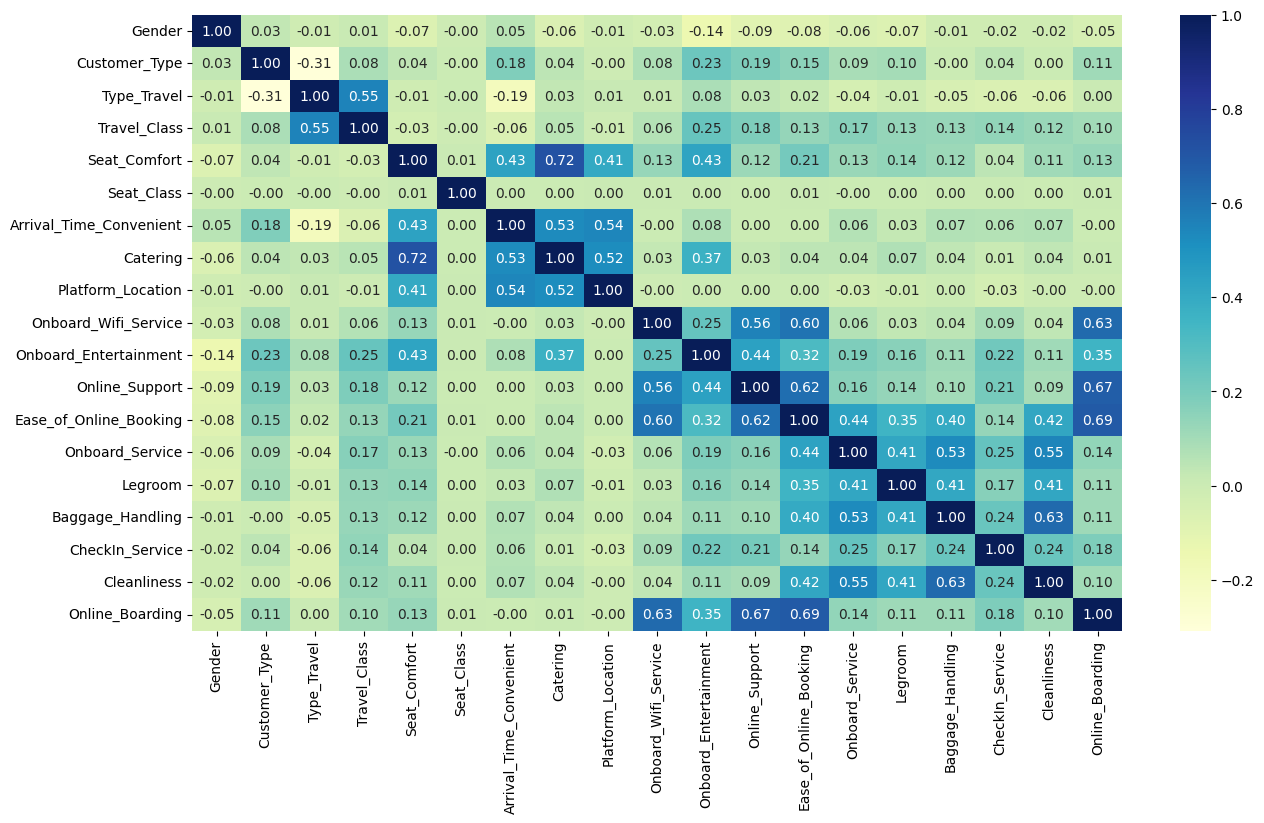

In [18]:
plt.figure(figsize=(15,8))
sns.heatmap(dfCopy_train[cat_cols].corr(),annot=True, fmt='0.2f', cmap='YlGnBu')

<AxesSubplot: >

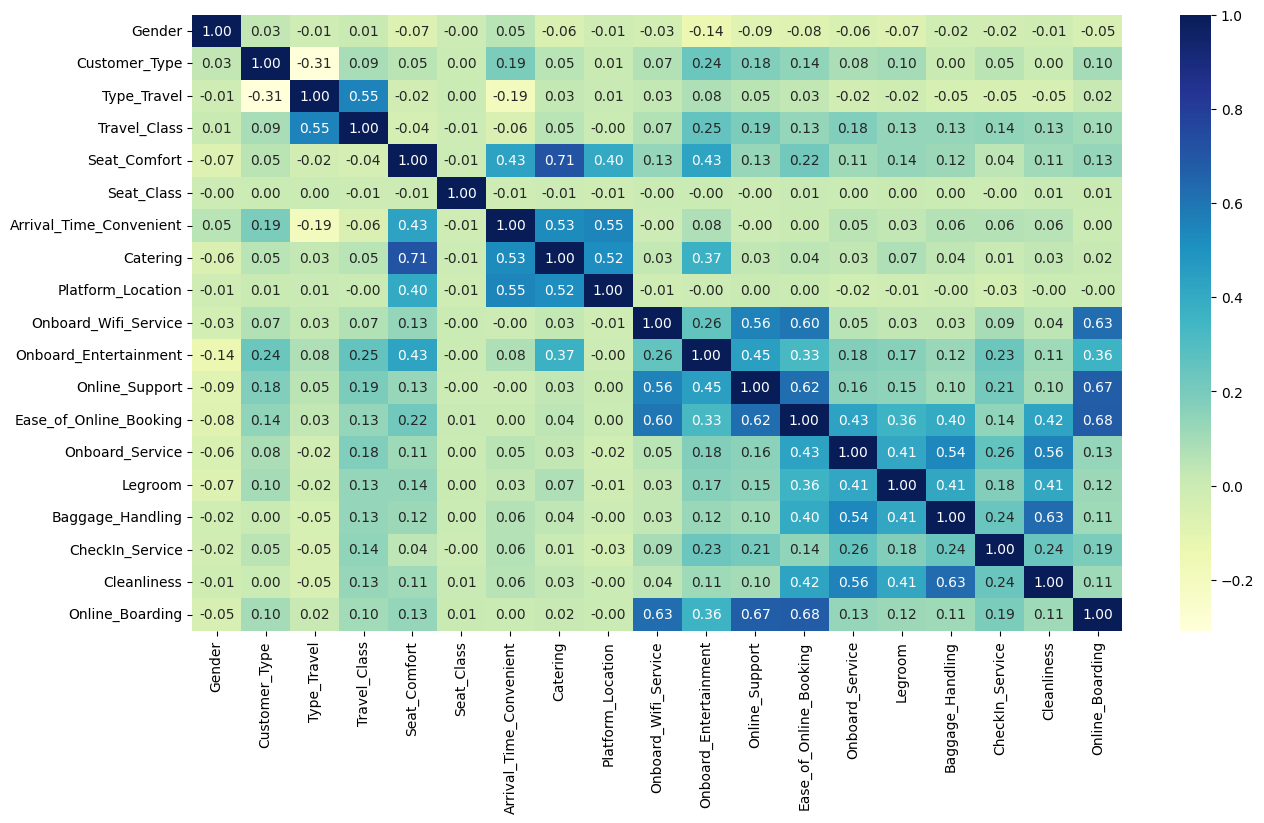

In [19]:
plt.figure(figsize=(15,8))
sns.heatmap(dfCopy_test[cat_cols].corr(),annot=True, fmt='0.2f', cmap='YlGnBu')

There are 3 clusters of correlation in there.  To me it looks like when someone is satisfied with an aspect of the service they will also be at least mostly satisfied with the other aspects.  **Let's do one more with all features.**

<AxesSubplot: >

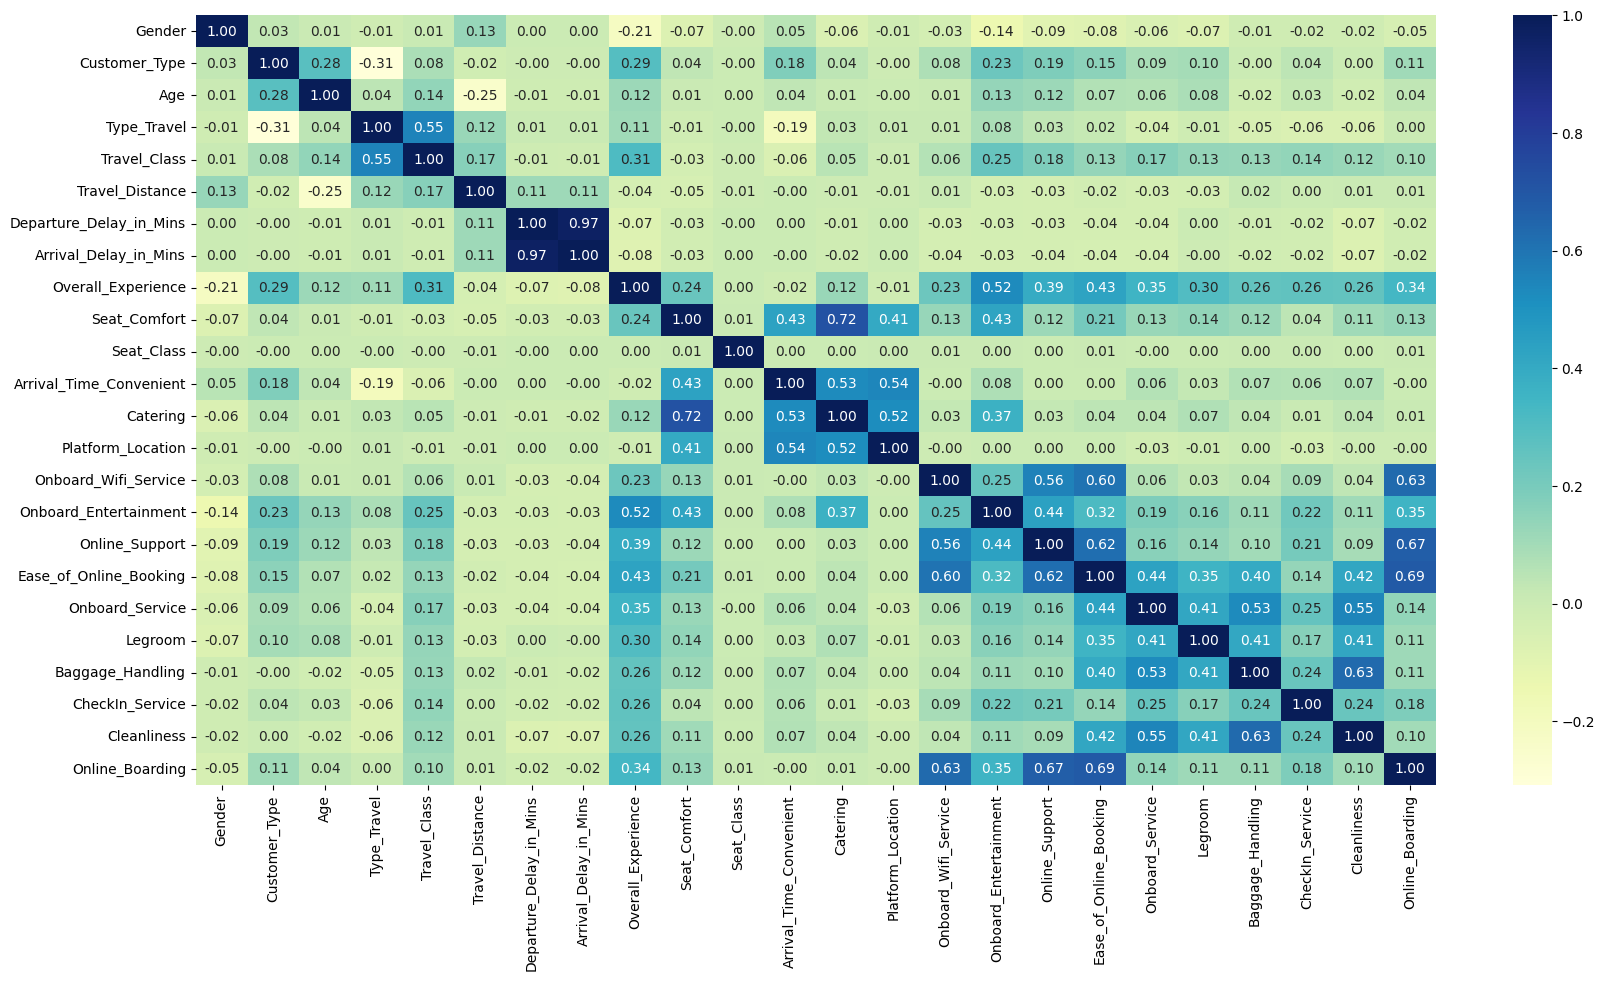

In [20]:
plt.figure(figsize=(20,10))
sns.heatmap(dfCopy_train.corr(),annot=True, fmt='0.2f', cmap='YlGnBu')

<AxesSubplot: >

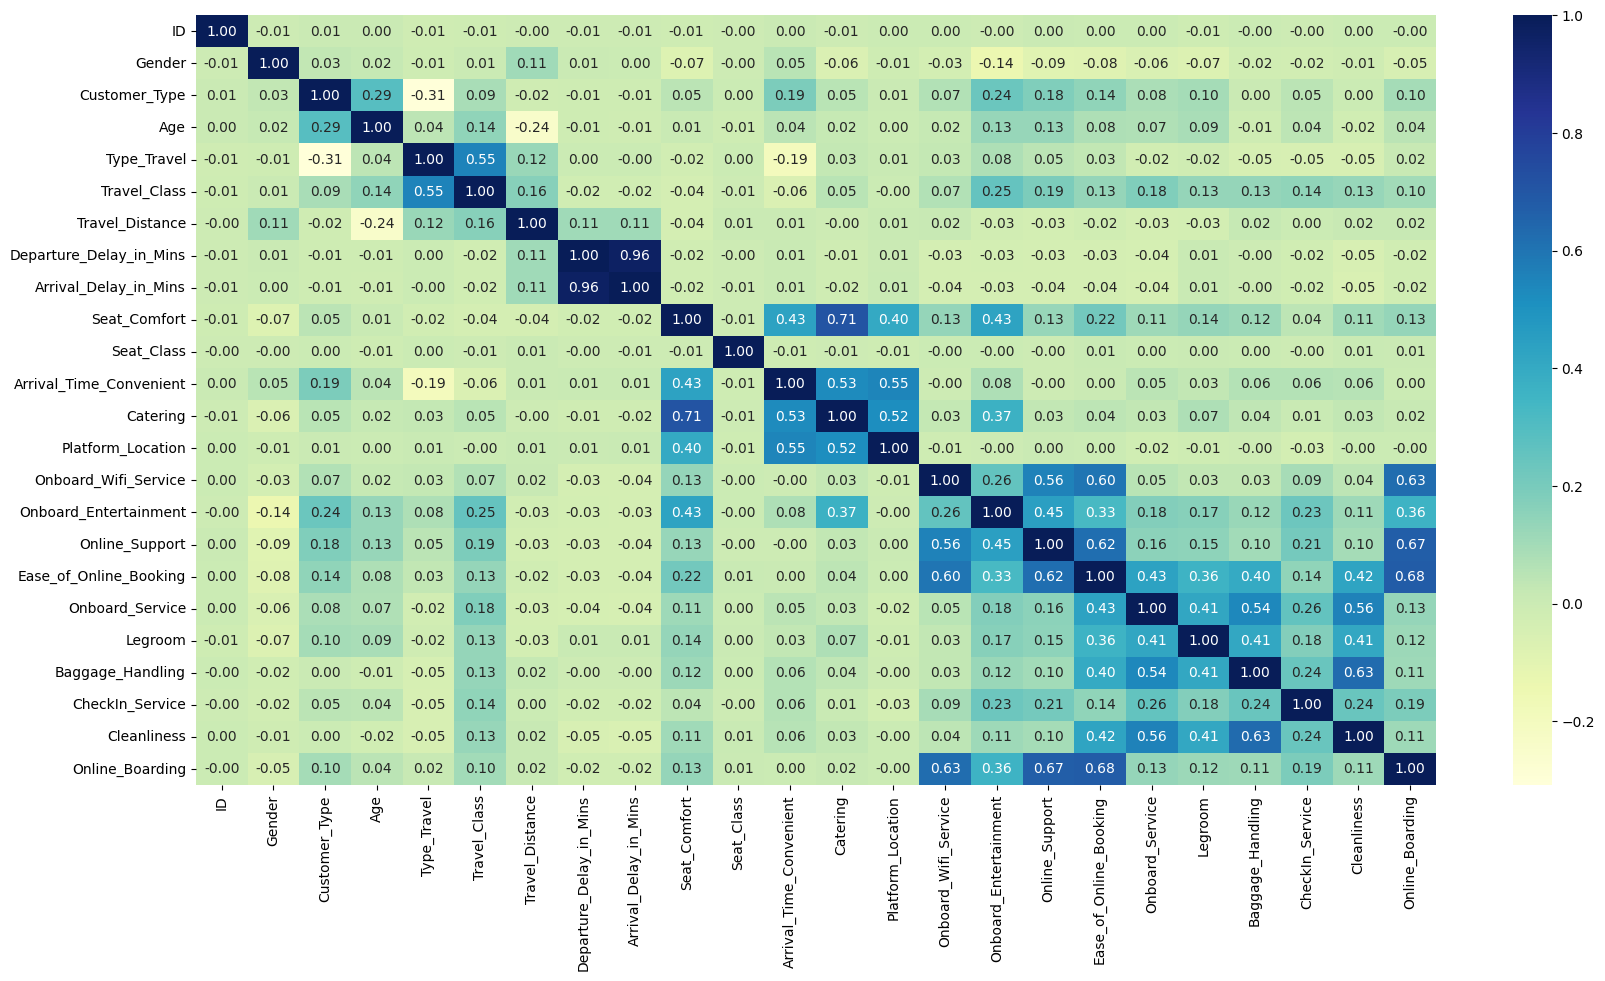

In [21]:
plt.figure(figsize=(20,10))
sns.heatmap(dfCopy_test.corr(),annot=True, fmt='0.2f', cmap='YlGnBu')

 We need to impute and check on null data then see if this impact correlation overall.


In [22]:
X = dfCopy_train.drop(['Overall_Experience'],axis=1)
Y = dfCopy_train[['Overall_Experience']]

X_test_copy = dfCopy_test.copy(deep=True)
X_train_copy = X.copy(deep=True)
y_train_copy = Y.copy(deep=True)

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 2, random_state = 42,stratify = Y)


Since we have a lot of missing values all around we will need to talk to decide if we impute or drop them.  For now, since we want a base line I'll just impute them using a simple approach taking the median value for the arrival and departure.  We can get fancier later on.


In [23]:

imputer_mode = SimpleImputer(strategy="median")

X_train[["Departure_Delay_in_Mins","Arrival_Delay_in_Mins"]] = imputer_mode.fit_transform(X_train[["Departure_Delay_in_Mins","Arrival_Delay_in_Mins"]])
X_test[["Departure_Delay_in_Mins","Arrival_Delay_in_Mins"]] = imputer_mode.transform(X_test[["Departure_Delay_in_Mins","Arrival_Delay_in_Mins"]])

X_test_copy[["Departure_Delay_in_Mins","Arrival_Delay_in_Mins"]] = imputer_mode.fit_transform(X_test_copy[["Departure_Delay_in_Mins","Arrival_Delay_in_Mins"]])



In [24]:
#I made a bad call here.  We cant allocate mean to cat variables...  I need to rethink.
imputer_mode = SimpleImputer(strategy="most_frequent")

missing_values_var = ["Gender","Age","Seat_Comfort","Arrival_Time_Convenient","Catering","Platform_Location","Onboard_Wifi_Service","Onboard_Entertainment","Online_Support","Ease_of_Online_Booking","Onboard_Service","Legroom","Baggage_Handling","CheckIn_Service","Cleanliness","Online_Boarding", "Customer_Type", "Type_Travel"]

X_train[missing_values_var] = imputer_mode.fit_transform(X_train[missing_values_var])
X_test[missing_values_var] = imputer_mode.transform(X_test[missing_values_var])
X_test_copy[missing_values_var] = imputer_mode.transform(X_test_copy[missing_values_var])


In [25]:
X_test.isnull().sum()


Gender                     0
Customer_Type              0
Age                        0
Type_Travel                0
Travel_Class               0
Travel_Distance            0
Departure_Delay_in_Mins    0
Arrival_Delay_in_Mins      0
Seat_Comfort               0
Seat_Class                 0
Arrival_Time_Convenient    0
Catering                   0
Platform_Location          0
Onboard_Wifi_Service       0
Onboard_Entertainment      0
Online_Support             0
Ease_of_Online_Booking     0
Onboard_Service            0
Legroom                    0
Baggage_Handling           0
CheckIn_Service            0
Cleanliness                0
Online_Boarding            0
dtype: int64

# Models


In [26]:
# Creating metric function 
def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))

    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8,5))
    
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels=['Overall Experience 0', 'Overall Experience 1'], yticklabels=['Overall Experience 0', 'Overall Experience 1'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

## Logistic Reg


In [27]:
# Scaling the data
sc=StandardScaler()

# Fit_transform on train data
X_train_scaled=sc.fit_transform(X_train)
X_train_scaled=pd.DataFrame(X_train_scaled, columns=X.columns)

# Transform on test data
X_test_scaled=sc.transform(X_test)
X_test_scaled=pd.DataFrame(X_test_scaled, columns=X.columns)

X_test_copy_scaled = sc.transform(X_test_copy.loc[ : , X_test_copy.columns != 'ID'])

lg=LogisticRegression()
lg.fit(X_train_scaled,y_train)


LogisticRegression()

              precision    recall  f1-score   support

           0       0.82      0.81      0.81     42785
           1       0.84      0.85      0.85     51592

    accuracy                           0.83     94377
   macro avg       0.83      0.83      0.83     94377
weighted avg       0.83      0.83      0.83     94377



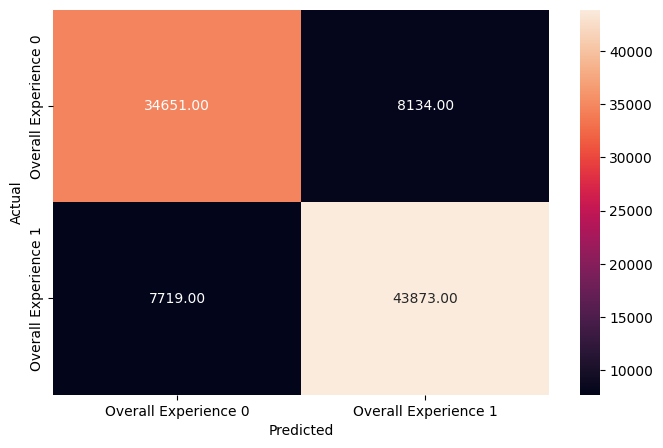

In [28]:
y_pred_train = lg.predict(X_train_scaled)

metrics_score(y_train, y_pred_train)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



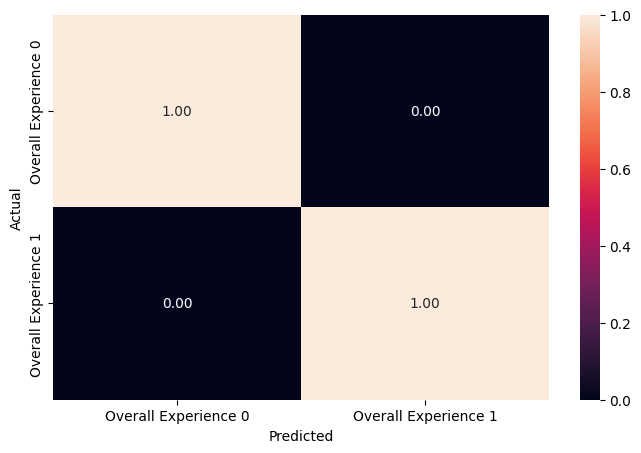

In [29]:
y_pred_test = lg.predict(X_test_scaled)

metrics_score(y_test, y_pred_test)

In [30]:
cols=X.columns

coef_lg=lg.coef_

pd.DataFrame(coef_lg,columns=cols).T.sort_values(by = 0,ascending = False)

,0
Onboard_Entertainment,0.942372
Customer_Type,0.642825
Travel_Class,0.440708
Ease_of_Online_Booking,0.365876
Seat_Comfort,0.361226
CheckIn_Service,0.350541
Onboard_Service,0.342477
Legroom,0.284110
Type_Travel,0.238053
Online_Boarding,0.184913


In [31]:
#Submission for testing purposes of logistic regression...

y_pred_test_submission = lg.predict(X_test_copy_scaled)
X_test_log_reg = X_test_copy.copy(deep=True)
X_test_log_reg['Overall_Experience'] = y_pred_test_submission

(X_test_log_reg.loc[:,['ID','Overall_Experience']]).to_csv('submission_lin_reg.csv',index=False)

X_test_log_reg.shape

(35602, 25)

## XGBoost (random search and grid search)

In [32]:
#We attempt a random search for hp tuning of xgboost.

from numpy.ma.bench import timer
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_wine
#model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')


# A parameter grid for XGBoost
params = {
    'min_child_weight': [1, 2,3,4,5, 6,7,8,9,10],
    'n_estimators':[100,200,300,400,500,510,520,530,540,550,560,570,580,590,600,700,800],
    'gamma': [0.1,0.2,0.3,0.4,0.5,0.6, 0.7,0.8,0.9,1,1.1,1.2,1.3,1.4, 1.5, 1.6,1.7,1.8,1.9,2,3,4, 5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10,11,12],
    'subsample': [0.6,0.1,0.2,0.3,0.4,0.5, 0.7,0.8,0.85,0.9, 0.95,1.0],
    'colsample_bytree': [0.1,0.2,0.3,0.4,0.5,0.6, 0.8,0.9,0.95,0.96,0.97,0.98,0.99 ,1.0],
    'max_depth': [3, 4, 5,6,7,8,9,10,11,12,13,14,15,16,17,18,20,22,26,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65]
}


#model = XGBClassifier(learning_rate=0.01, n_estimators=600, objective='binary:logistic',   silent=True, nthread=1)
model = XGBClassifier(learning_rate=0.01, objective='binary:logistic',  tree_method='gpu_hist',  silent=True, nthread=1)
folds = 8
param_comb = 10

skf = StratifiedKFold(n_splits=folds, shuffle = True)

random_search = RandomizedSearchCV(model, param_distributions=params, n_iter=param_comb, scoring='accuracy', n_jobs=-2, cv=skf.split(X_train_scaled,y_train), verbose=10 )
#GridSearchCV
# Here we go
random_search.fit(X_train_scaled,y_train)

#Submission for RF with gradientboost
y_pred_test_submission = random_search.predict(X_test_copy_scaled)

X_test_xgb_cv= X_test_copy.copy(deep=True)
X_test_xgb_cv['Overall_Experience'] = y_pred_test_submission

(X_test_xgb_cv.loc[:,['ID','Overall_Experience']]).to_csv('submission_xgb_cvfulldsAccuracy2.csv',index=False)

X_test_xgb_cv.shape

Fitting 8 folds for each of 10 candidates, totalling 80 fits
[CV 5/8; 1/10] START colsample_bytree=1.0, gamma=3, max_depth=34, min_child_weight=1, n_estimators=580, subsample=0.9
[CV 5/8; 1/10] END colsample_bytree=1.0, gamma=3, max_depth=34, min_child_weight=1, n_estimators=580, subsample=0.9;, score=nan total time=   2.9s
[CV 8/8; 3/10] START colsample_bytree=0.95, gamma=1.7, max_depth=11, min_child_weight=10, n_estimators=520, subsample=0.9
[CV 8/8; 3/10] END colsample_bytree=0.95, gamma=1.7, max_depth=11, min_child_weight=10, n_estimators=520, subsample=0.9;, score=nan total time=   0.0s
[CV 1/8; 4/10] START colsample_bytree=0.5, gamma=1.2, max_depth=35, min_child_weight=3, n_estimators=510, subsample=0.85
[CV 1/8; 4/10] END colsample_bytree=0.5, gamma=1.2, max_depth=35, min_child_weight=3, n_estimators=510, subsample=0.85;, score=nan total time=   0.2s
[CV 2/8; 4/10] START colsample_bytree=0.5, gamma=1.2, max_depth=35, min_child_weight=3, n_estimators=510, subsample=0.85
[CV 2/8; 

(35602, 25)

In [33]:
#We now do a grid search for hp tuning of xgboost

import numpy as np
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_class_weight
from numpy.ma.bench import timer
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_wine


#class_weights = compute_class_weight('balanced')

random_state = np.random.randint(0, 1000)
params = {
    'min_child_weight': [1, 2,3,4,5, 6,7,8,9,10],
    'learning_rate': [0.1],
    'n_estimators':[500,510,520,530,540,550,560,570,580,590,600,700,800],
    'gamma': [0.1,0.2,0.3,0.4,0.5,0.6, 0.7,0.8,0.9,1,1.1,1.2,1.3,1.4, 1.5, 1.6,1.7,1.8,1.9,2,3,4, 5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10,11,12],
    'subsample': [0.6,0.1,0.2,0.3,0.4,0.5, 0.7,0.8,0.85,0.9, 0.95,1.0],
    'colsample_bytree': [0.1,0.2,0.3,0.4,0.5,0.6, 0.8,0.9,0.95,0.96,0.97,0.98,0.99 ,1.0],
    'max_depth': [3, 4, 5,6,7,8,9,10,11,12,13,14,15,16,17,18,20,22,26,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65]
}
params_light = {
    'min_child_weight': [0,1],
    'learning_rate': [0.1],
    'n_estimators':[400,500],
    'gamma': [0.5,1, 1.5],
    'subsample': [0.8,0.9, 0.95,1.0],
    'colsample_bytree': [0.5, 0.8,0.9 ,1.0],
    'max_depth': [30,55]
}

parameters =    {
    'max_depth': [ 5],
    'learning_rate': [0.1],
    'n_estimators': [ 100],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [0, 0.5, 1],
    'max_delta_step': [0],
    'subsample': [ 0.8, 0.9, 1],
    'colsample_bytree': [ 0.8, 1],
    'colsample_bylevel': [1],
    'reg_alpha': [0, 1],
    'reg_lambda': [0,  1],
    'base_score': [0.5]
}

xgb_model = XGBClassifier(objective='binary:logistic',  tree_method='gpu_hist', nthread=1)
#xgb.XGBClassifier(scale_pos_weight = class_weights, silent = True,
            #                  random_state = random_state)

clf = GridSearchCV(xgb_model, params_light, scoring = 'accuracy', n_jobs = 1, cv = 5,verbose=10)
clf.fit(X_train_scaled,y_train)

#Submission for RF with gradientboost
y_pred_test_submission = clf.predict(X_test_copy_scaled)

X_test_xgb_cv= X_test_copy.copy(deep=True)
X_test_xgb_cv['Overall_Experience'] = y_pred_test_submission

(X_test_xgb_cv.loc[:,['ID','Overall_Experience']]).to_csv('submission_xgb_GPU_parameters_1.csv',index=False)

X_test_xgb_cv.shape
model = clf.best_estimator_

Fitting 5 folds for each of 384 candidates, totalling 1920 fits
[CV 1/5; 1/384] START colsample_bytree=0.5, gamma=0.5, learning_rate=0.1, max_depth=30, min_child_weight=0, n_estimators=400, subsample=0.8
[CV 1/5; 1/384] END colsample_bytree=0.5, gamma=0.5, learning_rate=0.1, max_depth=30, min_child_weight=0, n_estimators=400, subsample=0.8;, score=0.955 total time=   3.6s
[CV 2/5; 1/384] START colsample_bytree=0.5, gamma=0.5, learning_rate=0.1, max_depth=30, min_child_weight=0, n_estimators=400, subsample=0.8
[CV 2/5; 1/384] END colsample_bytree=0.5, gamma=0.5, learning_rate=0.1, max_depth=30, min_child_weight=0, n_estimators=400, subsample=0.8;, score=0.956 total time=   3.7s
[CV 3/5; 1/384] START colsample_bytree=0.5, gamma=0.5, learning_rate=0.1, max_depth=30, min_child_weight=0, n_estimators=400, subsample=0.8
[CV 3/5; 1/384] END colsample_bytree=0.5, gamma=0.5, learning_rate=0.1, max_depth=30, min_child_weight=0, n_estimators=400, subsample=0.8;, score=0.957 total time=   3.5s
[CV

KeyboardInterrupt: 

## SVM -- Support Vector Machine


In [ ]:
# Fitting SVM
svm = SVC(kernel='linear') # Linear kernel or linear decision boundary
model = svm.fit(X= X_train_scaled, y = y_train)


In [ ]:
y_pred_train_svm = model.predict(X_train_scaled)

metrics_score(y_train, y_pred_train_svm)

In [ ]:
y_pred_test_svm = model.predict(X_test_scaled)

metrics_score(y_test, y_pred_test_svm)

In [ ]:
#This time with the rbf kernel
svm_rbf=SVC(kernel='rbf',probability=True)
# Fit the model
svm_rbf.fit(X_train_scaled,y_train)
# Predict on train data
y_scores_svm=svm_rbf.predict_proba(X_train_scaled)

precisions_svm, recalls_svm, thresholds_svm = precision_recall_curve(y_train, y_scores_svm[:,1])

# Plot values of precisions, recalls, and thresholds
plt.figure(figsize=(10,7))
plt.plot(thresholds_svm, precisions_svm[:-1], 'b--', label='precision')
plt.plot(thresholds_svm, recalls_svm[:-1], 'g--', label = 'recall')
plt.xlabel('Threshold')
plt.legend(loc='upper left')
plt.ylim([0,1])
plt.show()

In [ ]:
optimal_threshold_svm=.5
y_pred_train = svm_rbf.predict_proba(X_train_scaled)

metrics_score(y_train, y_pred_train[:,1]>optimal_threshold_svm)

In [ ]:
y_pred_test = svm_rbf.predict_proba(X_test_scaled)

metrics_score(y_test, y_pred_test[:,1]>optimal_threshold_svm)

In [ ]:
#Submission for SVM RBF

optimal_threshold_svm=.5
y_pred_test_submission = svm_rbf.predict_proba(X_test_copy_scaled)
X_test_svc_rbf = X_test_copy.copy(deep=True)
X_test_svc_rbf['Overall_Experience'] = (y_pred_test_submission[:,1]>optimal_threshold_svm).astype(int)

(X_test_svc_rbf.loc[:,['ID','Overall_Experience']]).to_csv('submission_svm_rbf.csv',index=False)

X_test_svc_rbf.shape
#metrics_score(y_test, y_pred_test[:,1]>optimal_threshold_svm)

## RandomForest (see random forest with gridsearch)

In [ ]:
rf_estimator = RandomForestClassifier(class_weight = {0: 0.17, 1: 0.83})
#rf_estimator = RandomForestClassifier(class_weight = {0: 1, 1: 0.1})
rf_estimator.fit(X_train_scaled, y_train)

y_pred_train_rf = rf_estimator.predict(X_train_scaled)

metrics_score(y_train, y_pred_train_rf)



In [ ]:
y_pred_test_rf = rf_estimator.predict(X_test_scaled)

metrics_score(y_test, y_pred_test_rf)

In [ ]:
X_train.columns

In [ ]:
importances = rf_estimator.feature_importances_
#
# Sort the feature importance in descending order
#
sorted_indices = np.argsort(importances)[::-1]
 
feat_labels = X_train.columns
 
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                            feat_labels[sorted_indices[f]],
                            importances[sorted_indices[f]]))

In [ ]:
#Submission for baseline RF
y_pred_test_submission = rf_estimator.predict(X_test_copy_scaled)

X_test_rf= X_test_copy.copy(deep=True)
X_test_rf['Overall_Experience'] = y_pred_test_submission

(X_test_rf.loc[:,['ID','Overall_Experience']]).to_csv('submission_rf.csv',index=False)

X_test_rf.shape

**Gridsearch with Random Forest Classifier**

In [ ]:
#rf_estimator = RandomForestClassifier(class_weight = 'balanced')
#rf_estimator = RandomForestClassifier(class_weight = {0: 1, 1: 0.1})
#rf_estimator.fit(X_train, y_train)

#y_pred_train_rf = rf_estimator.predict(X_train)

#metrics_score(y_train, y_pred_train_rf)

#param_grid = {
#    'max_depth': [21, 25, 30],
    #'max_features': [2, 3],
    #'min_samples_leaf': [3, 4, 5],
    #'min_samples_split': [8, 10],
#    'n_estimators': [175, 200]
#}

param_grid = {
    'n_estimators': [165,170,171,172,173,174,175,176,177,178,179,180,185],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [40,41,42,43,45,46,48,50,51,52,53,54,55,56,57,58,59,60],
    'criterion' :['gini', 'entropy']
}

gs = GridSearchCV(estimator=RandomForestClassifier(class_weight = 'balanced', random_state=42),
                  param_grid= param_grid,
                  scoring='accuracy',
                  cv=5,
                  n_jobs=-1)

scores = cross_val_score(gs, X_train_scaled, y_train,
                         scoring='accuracy', cv=5)
print(f'CV accuracy: {np.mean(scores):.3f} '
      f'+/- {np.std(scores):.3f}')


gs.fit(X_train_scaled, y_train)
gs.best_params_

y_pred_test_rf = gs.predict(X_test_scaled)

metrics_score(y_test, y_pred_test_rf)
print(gs.best_params_)


In [ ]:
#Submission for RF with CV max_depth:25 and n_estimators:175
y_pred_test_submission = gs.predict(X_test_copy_scaled)

X_test_rf_cv= X_test_copy.copy(deep=True)
X_test_rf_cv['Overall_Experience'] = y_pred_test_submission

(X_test_rf_cv.loc[:,['ID','Overall_Experience']]).to_csv('submission_rf_cvXaftersearch.csv',index=False)

X_test_rf_cv.shape

